In [1]:
# matplotlib plots within notebook
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

from datetime import datetime
from tqdm import tqdm

import os, sys, shutil
import pickle


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


from l5kit.configs import load_config_data
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
import l5kit
print('Using l5kit version: '+l5kit.__version__)



# Custom libs
#sys.path.insert(0, './LyftAgent_lib')
os.chdir('/tf/2020-10-Lyft/Code/')
from LyftAgent_lib import train_support as lyl_ts
from LyftAgent_lib import topologies as lyl_nn

# Print Code Version
#import git
#def print_git_info(path, nombre):
#    repo = git.Repo(path)
#    print('Using: %s \t branch %s \t commit hash %s'%(nombre, repo.active_branch.name, repo.head.object.hexsha))
#    changed = [ item.a_path for item in repo.index.diff(None) ]
#    if len(changed)>0:
#        print('\t\t WARNING -- modified files:')
#        print(changed)    
#print_git_info('.', 'LyftAgent_lib')


import platform
print("python: "+platform.python_version())


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
print('Using TensorFlow version: '+tf.__version__)
print('Using Keras version: '+keras.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using l5kit version: 1.1.0
python: 3.6.9
Using TensorFlow version: 2.3.1
Using Keras version: 2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 676806099108293446
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16190974488716748982
physical_device_desc: "device: XLA_CPU device"
]


# Training and Model Config

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/tf/2020-10-Lyft/prediction-dataset"
# get config
cfg = load_config_data("./AgentPrediction_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'version': 'V2', 'CarNet': False, 'increment_net': True, 'pathDec_use_attention_hist': False, 'pathDec_use_attention_img': False, 'use_fading': True, 'base_image_model': 'MobileNetV2', 'base_image_preprocess': 'mobilenet_v2.preprocess_input', 'history_encoder_recurrent_unit': 'GRU', 'history_encoder_recurrent_units_number': 256, 'num_hist_encode_layers': 3, 'hist_encode_units': [8, 32, 128], 'hist_encode_activation': 'relu', 'path_generation_decoder_recurrent_unit': 'GRU', 'path_generation_decoder_recurrent_units_number': 256, 'pathDec_attention_pr_units': 64, 'num_path_decode_fc_layers': 3, 'path_decode_fc_units': [1024, 128, 8], 'path_decode_fc_activation': 'relu', 'path_noise_level': 1.0, 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'training_params': {'gen_lr_list': [0.001, 0.0001, 1e-05, 5e-06, 1e-06], 'gen_lr_lims': [2, 10, 20, 40, 100]

In [3]:
# Get parameters
model_map_input_shape      = (cfg["raster_params"]["raster_size"][0],
                              cfg["raster_params"]["raster_size"][1])

base_image_arch            = cfg["model_params"]["base_image_model"]
base_image_preprocess      = cfg["model_params"]["base_image_preprocess"]

num_future_frames          = cfg["model_params"]["future_num_frames"]

num_hist_frames            = cfg["model_params"]["history_num_frames"]


histEnc_recurrent_unit     = cfg["model_params"]["history_encoder_recurrent_unit"]
histEnc_recurrent_unit_num = cfg["model_params"]["history_encoder_recurrent_units_number"]
pathDec_recurrent_unit     = cfg["model_params"]["path_generation_decoder_recurrent_unit"]
pathDec_recurrent_unit_num = cfg["model_params"]["path_generation_decoder_recurrent_units_number"]



gen_batch_size             = cfg["train_data_loader"]["batch_size"]
gen_lr_list                = cfg["training_params"]["gen_lr_list"]
gen_lr_lims                = cfg["training_params"]["gen_lr_lims"]


number_of_scenes           = cfg["training_params"]["number_of_scenes"]
frames_per_scene           = cfg["training_params"]["frames_per_scene"]
randomize_frames           = cfg["training_params"]["randomize_frames"]
randomize_scenes           = cfg["training_params"]["randomize_scenes"]
epochs_train               = cfg["training_params"]["epochs_train"]
# teacher_force_decay        = cfg["training_params"]["teacher_force_decay"]
teacher_force_list         = cfg["training_params"]["teacher_force_list"]
teacher_force_lims         = cfg["training_params"]["teacher_force_lims"]


use_teacher_force          = cfg["training_params"]["use_teacher_force"]
init_decoder_on_history    = cfg["training_params"]["init_decoder_on_history"]
retrain_inputs_image_model = cfg["training_params"]["retrain_inputs_image_model"]
retrain_all_image_model = cfg["training_params"]["retrain_all_image_model"]

future_steps_train_list    = cfg["training_params"]["future_steps_train_list"]
future_steps_train_lims    = cfg["training_params"]["future_steps_train_lims"]
use_modulate_future_steps  = cfg["training_params"]["use_modulate_future_steps"]


model_version              = cfg["model_params"]["version"]
use_fading                 = cfg["model_params"]["use_fading"]

map_input_channels = 3+2


# loss_function = [lyl_ts.L_loss_single2mult]
loss_function = [lyl_ts.L_loss_single2mult, lyl_ts.L2_loss]
loss_couplings = [1.0, 1.0]
loss_names = ['Likelihood', 'MSE']


# Epoch to restart training (0 means start over)
restart_epoch = 0
isBaseModel = False
if model_version == 'Base':
    isBaseModel = True
    forward_pass_use = lyl_nn.modelBaseline_forward_pass
    save_path = './output_Baseline'
elif model_version == 'V1':
    forward_pass_use = lyl_nn.modelV1_forward_pass
    save_path = './output_V1_likelihood'
elif model_version == 'V2':
    forward_pass_use = lyl_nn.modelV2_forward_pass
    save_path = './output_V2_noAttn_big_multiLoss_imgRetrain'
    cfg["model_params"]["history_encoder_recurrent_units_number"] = cfg["model_params"]["path_generation_decoder_recurrent_units_number"]


In [4]:
# Get image preprocessing function (depends on image encoding base architecture)
if base_image_preprocess == None:
    base_image_preprocess_fcn = lambda x: x
else:
    try:
        base_image_preprocess_fcn = getattr(keras.applications, base_image_preprocess.split('.')[0])
        base_image_preprocess_fcn = getattr(base_image_preprocess_fcn, base_image_preprocess.split('.')[1])
    except:
        raise Exception('Base image pre-processing not found. Requested function: %s'%base_image_preprocess) 

# Dataset Loader

### Train Set

In [5]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["train_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open(cached=False)
print(zarr_dataset)
rast = build_rasterizer(cfg, dm)
train_dataset = AgentDataset(cfg, zarr_dataset, rast, min_frame_future = 10)
number_of_scenes = len(train_dataset.dataset.scenes)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: you're running with custom min_frame_future of 10
  import sys


In [6]:
tf_train_dataset = lyl_ts.get_tf_dataset(train_dataset, 
                                         num_hist_frames,
                                         model_map_input_shape,
                                         num_future_frames,
                                         randomize_frame=randomize_frames,
                                         randomize_scene=randomize_scenes, 
                                         num_scenes=number_of_scenes, 
                                         frames_per_scene = frames_per_scene)

# Map sample pre-processing function
tf_train_dataset = tf_train_dataset.map(lambda x: lyl_ts.tf_get_input_sample(x, 
                                                                             image_preprocess_fcn=base_image_preprocess_fcn, 
                                                                             use_fading = use_fading))
# Shuffle dataset
# tf_train_dataset = tf_train_dataset.shuffle(buffer_size=64, reshuffle_each_iteration=True)#.repeat(-1)
# Set batch size
tf_train_dataset = tf_train_dataset.batch(batch_size=gen_batch_size)

    

Creating dataset with: 
	 Randomized scenes: True
	 Randomized frames: True
	 Number of scenes: 16265
	 Number of frames per scenes: 1


### Validation Set

In [7]:
dm_val = LocalDataManager()
dataset_path_val = dm_val.require(cfg["val_data_loader"]["key"])
zarr_dataset_val = ChunkedDataset(dataset_path_val)
zarr_dataset_val.open(cached=False)
print(zarr_dataset_val)
rast_val = build_rasterizer(cfg, dm_val)
validation_dataset = AgentDataset(cfg, zarr_dataset_val, rast_val, min_frame_future = 10)
number_of_scenes_val = len(validation_dataset.dataset.scenes)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |    29277930   |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: you're running with custom min_frame_future of 10
  import sys


In [8]:
tf_validation_dataset = lyl_ts.get_tf_dataset(validation_dataset, 
                                              num_hist_frames,
                                              model_map_input_shape,
                                              num_future_frames,
                                              randomize_frame=True,
                                              randomize_scene=True, 
                                              num_scenes=number_of_scenes_val, 
                                              frames_per_scene = frames_per_scene)

# Map sample pre-processing function
tf_validation_dataset = tf_validation_dataset.map(lambda x: lyl_ts.tf_get_input_sample(x,                                                                                                                                 image_preprocess_fcn=base_image_preprocess_fcn,
                                                                                    use_fading = use_fading))
# Shuffle dataset
# tf_validation_dataset = tf_validation_dataset.shuffle(buffer_size = 64, reshuffle_each_iteration=False)#.repeat(-1)
# Set batch size
tf_validation_dataset = tf_validation_dataset.batch(batch_size=gen_batch_size)

Creating dataset with: 
	 Randomized scenes: True
	 Randomized frames: True
	 Number of scenes: 16220
	 Number of frames per scenes: 1


# Build Models

In [9]:

# Pick up from previous step
if restart_epoch>0:
    custom_layers_dict = {'BahdanauAttention': lyl_nn.BahdanauAttention, 'LeakyReLU': keras.layers.LeakyReLU}

    if retrain_inputs_image_model or retrain_all_image_model:
        ImageEncModel = lyl_ts.load_model(os.path.join(save_path, 'ImageEncModel'), 'epoch_%d'%(restart_epoch), use_keras=True,  custom_obj_dict=custom_layers_dict)
    else:
        ImageEncModel = lyl_ts.load_model(os.path.join(save_path, 'ImageEncModel'), 'all_epochs', use_keras=True, custom_obj_dict=custom_layers_dict)
    
    if not isBaseModel:
        HistEncModel = lyl_ts.load_model(os.path.join(save_path, 'HistEncModel'), 'epoch_%d'%(restart_epoch), use_keras=True, custom_obj_dict=custom_layers_dict)
    else:
        HistEncModel = None

    
    PathDecModel = lyl_ts.load_model(os.path.join(save_path, 'PathDecModel'), 'epoch_%d'%(restart_epoch), use_keras=True, custom_obj_dict=custom_layers_dict)
    
    print('All models succesfully loaded.')
else:
    
    # ---------------------- IMAGE ENCODER --------------------------
    # Load pretrained image processing model
    try:
        base_model_builder = getattr(keras.applications, base_image_arch)
    except:
        raise Exception('Base image processing model not found. Reuquested model: %s'%base_image_arch)


    base_img_model = base_model_builder(include_top=False, weights='imagenet')

    ImageEncModel = lyl_nn.imageEncodingModel(base_img_model, cfg)

    # ---------------------- PATH HISTORY ENCODER ------------------
    if not isBaseModel:
        HistEncModel = lyl_nn.pathEncodingModel(cfg)
    else:
        HistEncModel = None
    

    
    # ---------------------- PATH DECODER --------------------------
    if model_version == 'Base':
        PathDecModel = lyl_nn.pathDecoderModel_Baseline(cfg, ImageEncModel)
    elif model_version == 'V1':
        PathDecModel = lyl_nn.pathDecoderModel_V1(cfg, ImageEncModel, HistEncModel)
    elif model_version == 'V2':
        PathDecModel = lyl_nn.pathDecoderModel_V2(cfg, ImageEncModel, HistEncModel)

### Show model information

Model: "Image_Encodding_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_map (InputLayer)          [(None, 224, 224, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 1440        Input_map[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 111, 111, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 111, 111, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________

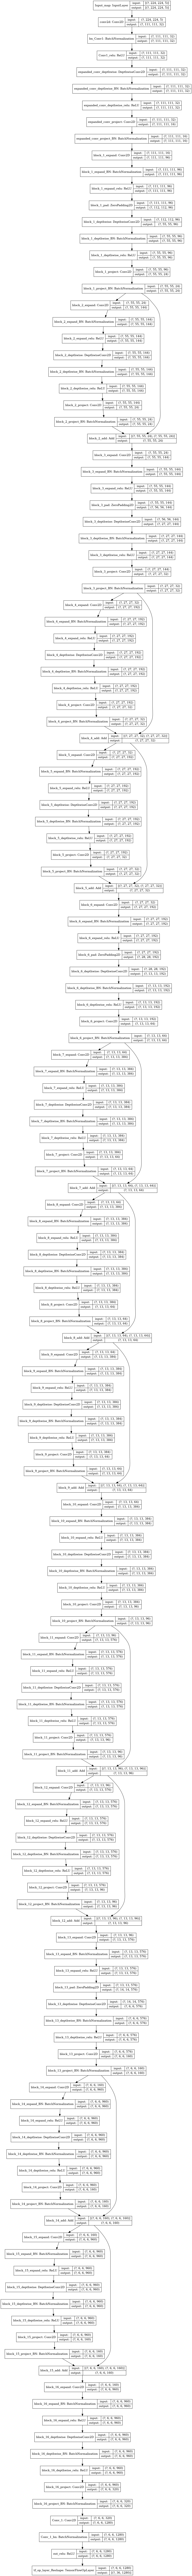

In [10]:
ImageEncModel.summary()
tf.keras.utils.plot_model(ImageEncModel, show_shapes=True, show_layer_names=True)

In [11]:
if not isBaseModel:
    HistEncModel.summary()
    tf.keras.utils.plot_model(HistEncModel, show_shapes=True, show_layer_names=True)

Model: "History_Encoding_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_history_frames (InputL [(32, 1, 3)]              0         
_________________________________________________________________
gaussian_noise (GaussianNois (32, 1, 3)                0         
_________________________________________________________________
dense (Dense)                (32, 1, 8)                32        
_________________________________________________________________
dense_1 (Dense)              (32, 1, 32)               288       
_________________________________________________________________
dense_2 (Dense)              (32, 1, 128)              4224      
_________________________________________________________________
histRecUnit (GRU)            [(32, 256), (32, 256)]    296448    
Total params: 300,992
Trainable params: 300,992
Non-trainable params: 0
______________________________________

Model: "Path_Decoder_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Image_Features (InputLaye [(32, 36, 1280)]     0                                            
__________________________________________________________________________________________________
Input_History_Out (InputLayer)  [(32, None, 256)]    0                                            
__________________________________________________________________________________________________
Input_position (InputLayer)     [(32, 3)]            0                                            
__________________________________________________________________________________________________
global_average_pooling1d (Globa (32, 1280)           0           Input_Image_Features[0][0]       
_________________________________________________________________________________

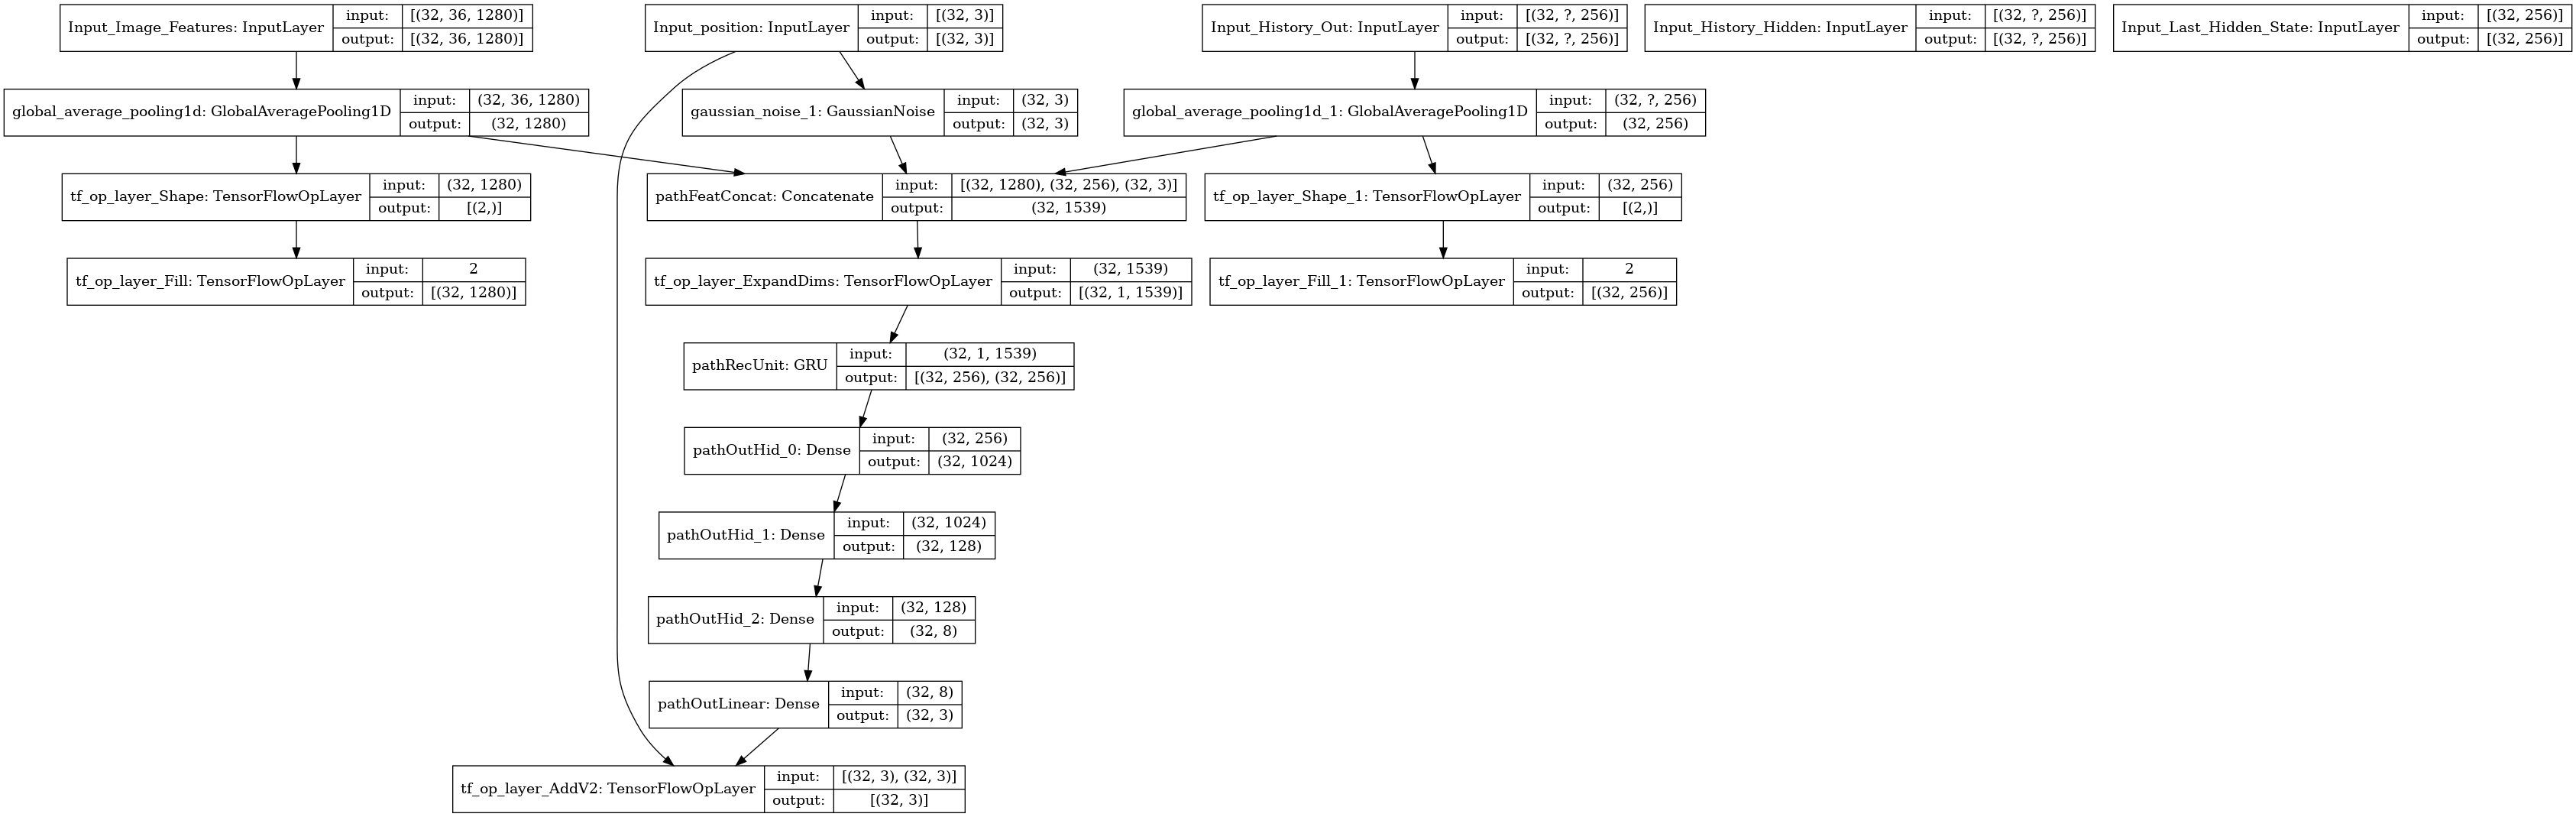

In [12]:
PathDecModel.summary()
tf.keras.utils.plot_model(PathDecModel, show_shapes=True, show_layer_names=True)


# Train!

In [13]:
# Set up TensorBoard
logdir = os.path.join(save_path,'TensorBoard_outs')

if os.path.exists(logdir) and restart_epoch==0:
    shutil.rmtree(logdir)
tb_writer = tf.summary.create_file_writer(os.path.join(logdir,'train'), name = 'train')

tb_writer_val = tf.summary.create_file_writer(os.path.join(logdir,'validation'), name = 'validation')


get_graph = False


In [14]:
optimizer_gen = keras.optimizers.Adam(lr=1.0, beta_1=0.9, beta_2=0.99, epsilon=1.0e-8)
train_genL2_loss = keras.metrics.Mean(name='train_gen_L2_loss')

# Load optimizer state
if restart_epoch>0:
    if os.path.exists(os.path.join(os.path.join(save_path,'OptimizerStates'), 'epoch_%d.npy'%(restart_epoch))):
        # Get list of trainable variables
        train_vars = ImageEncModel.trainable_variables
        if not isBaseModel:
            train_vars += HistEncModel.trainable_variables
        train_vars += PathDecModel.trainable_variables
                    
        lyl_ts.load_optimizer_state(os.path.join(save_path,'OptimizerStates'), 'epoch_%d'%(restart_epoch), optimizer_gen, train_vars)
    else:
        print('Warning - Optimizer state not loaded, using blank optimizer.')

    



In [15]:
teacher_force_base = 1.0
teacher_force = teacher_force_base   
if restart_epoch > 0:
    epoch_ini = restart_epoch+1
else:
    epoch_ini = 1
futureSteps_infer = num_future_frames
h_idx_all = list()
for epoch in range(epoch_ini, epochs_train+1):

    with tb_writer.as_default():
        idx_gen_train = 0
        steps_per_epoch = int(np.floor(number_of_scenes*frames_per_scene/gen_batch_size))
        this_step_num = idx_gen_train+(steps_per_epoch*(epoch-1))

        if use_modulate_future_steps:
            # Modulate number of future steps to train on
            futureSteps_infer = lyl_ts.get_future_steps_train(future_steps_train_list, 
                                                            future_steps_train_lims, 
                                                            epoch, 
                                                            futureSteps_infer)
        with tf.name_scope("Train_params"):
            tf.summary.scalar('obj_steps', futureSteps_infer, step=this_step_num)
    
        if not isBaseModel:
            if use_teacher_force:
                # Modulate teacher force
                teacher_force = lyl_ts.get_teacher_force_weight(teacher_force_list, 
                                                        teacher_force_lims, 
                                                        epoch, 
                                                        teacher_force, 
                                                        linearize=True)
                if teacher_force<=0.0:
                    use_teacher_force = False
                    print('Teacher force deactivated.')

            with tf.name_scope("Train_params"):
                tf.summary.scalar('teacher_force', teacher_force, step=this_step_num)


        #         teacher_force = teacher_force_base*np.exp(-epoch*teacher_force_decay)

        # Update learning rate
        this_lr = lyl_ts.update_lr(gen_lr_list, gen_lr_lims, epoch, optimizer_gen)
        with tf.name_scope("Train_params"):
            tf.summary.scalar('learning_rate', this_lr, step=this_step_num)
        
        # Flush stdout to avoid tqdm overlap
        sys.stdout.flush()
                                
        train_genL2_loss_aux = 0
        

        # List of hard examples
        h_example_idxs = list()
        h_example_loss = list()
        h_example_mean = list()
        example_log = list()
        
        
        train_dataset_prog_bar = tqdm(tf_train_dataset, total=steps_per_epoch)
        for (thisSampleMapComp, thisSampeHistPath, thisSampeTargetPath, 
            thisHistAvail, thisTargetAvail, 
            thisTimeStamp, thisTrackID, thisRasterFromAgent, thisWorldFromAgent, thisCentroid, thisSampleIdx) in train_dataset_prog_bar:


            this_step_num = idx_gen_train+(steps_per_epoch*(epoch-1))


            if thisSampleMapComp.shape[0] < gen_batch_size:
                break

            if get_graph:
                tf.summary.trace_on(graph=True, profiler=True)
                       

            if isBaseModel:
                step_losses, gradients_out  = lyl_ts.generator_train_step_Base(thisSampleMapComp,
                                                                        thisSampeTargetPath, 
                                                                        thisTargetAvail,
                                                                        ImageEncModel,
                                                                        PathDecModel, 
                                                                        optimizer_gen, 
                                                                        train_genL2_loss,
                                                                        forward_pass_use,
                                                                        loss_use = loss_function,
                                                                        gradient_clip_value = 10.0)
            else:
                PathDecModel.reset_states()
                HistEncModel.reset_states()
                
                step_losses, gradients_out = lyl_ts.generator_train_step(thisSampleMapComp,
                                                                        thisSampeHistPath, 
                                                                        thisSampeTargetPath, 
                                                                        thisHistAvail, 
                                                                        thisTargetAvail,
                                                                        ImageEncModel,
                                                                        HistEncModel, 
                                                                        PathDecModel, 
                                                                        optimizer_gen, 
                                                                        train_genL2_loss,
                                                                        tf.constant(tf.zeros(PathDecModel.inputs[-1].shape)),
                                                                        forward_pass_use,
                                                                        loss_use = loss_function,
                                                                        loss_couplings = loss_couplings,
                                                                        stepsInfer = futureSteps_infer,
                                                                        use_teacher_force=use_teacher_force,
                                                                        teacher_force_weight = tf.constant(teacher_force, 
                                                                                                                dtype=tf.float32),
                                                                        gradient_clip_value = 10.0,
                                                                        stop_gradient_on_prediction = False)

            if get_graph:
                tf.summary.trace_export(
                    name="train_step_trace",
                    step=0,
                    profiler_outdir=logdir)
                tf.summary.trace_off()
            get_graph = False


            thisL2 = train_genL2_loss.result()
            if np.isnan(thisL2):
                raise Exception('Bad potato... step %d'%idx_gen_train)
                
            train_genL2_loss_aux += thisL2
            train_genL2_loss.reset_states()


            print_gen_L2 = train_genL2_loss_aux/(idx_gen_train+1)

            comp_loss = 0
            for step_loss, k in zip(step_losses, loss_couplings):
                comp_loss += k*step_loss.numpy() 
            for thisLoss, thisIDX in zip(comp_loss, thisSampleIdx):
                example_log.append(thisIDX)
                if (thisLoss > 10.0*print_gen_L2):
                    h_example_idxs.append(thisIDX)
                    h_example_loss.append(thisLoss)
                    h_example_mean.append(print_gen_L2)
                                
            
            # Update progress bar
            msg_string = '(Epoch %d/%d) Gen. Loss: %.2f (last %.2f) '%(epoch,
                                                                            epochs_train,
                                                                            print_gen_L2, 
                                                                            thisL2)
            if use_teacher_force and not isBaseModel:
                msg_string += '(t.f. = %.2f)'%teacher_force
            train_dataset_prog_bar.set_description(msg_string)


            # Save info to tensorboard
            with tf.name_scope("Loss_metrics"):
                for this_name, this_loss in zip(loss_names, step_losses):
                    tf.summary.scalar(this_name, np.mean(this_loss.numpy()), step=this_step_num)

            grad_out_count = 0
            if (len(gradients_out) == 3 and not isBaseModel) or (len(gradients_out) == 2 and isBaseModel):
                with tf.name_scope("Gradient_ImgEncModel"):
                    for grad, var in zip(gradients_out[grad_out_count], ImageEncModel.trainable_variables):
                        tf.summary.scalar(var.name+'_norm', np.linalg.norm(var.numpy()), step=this_step_num)
                grad_out_count += 1
            if not isBaseModel:
                with tf.name_scope("Gradient_HistEncModel"):
                    for grad, var in zip(gradients_out[grad_out_count], HistEncModel.trainable_variables):
                        tf.summary.scalar(var.name+'_norm', np.linalg.norm(var.numpy()), step=this_step_num)
                    grad_out_count += 1
            with tf.name_scope("Gradient_PathDecModel"):
                for grad, var in zip(gradients_out[grad_out_count], PathDecModel.trainable_variables):
                    tf.summary.scalar(var.name+'_norm', np.linalg.norm(var.numpy()), step=this_step_num)
                grad_out_count += 1

            if this_step_num % 100 == 0:
                if (len(gradients_out) == 3 and not isBaseModel) or (len(gradients_out) == 2 and isBaseModel):
                    with tf.name_scope("ImageEncodingModel"):
                        for weights, layer in zip(ImageEncModel.get_weights(), ImageEncModel.trainable_variables):
                            tf.summary.histogram(layer.name, weights, step=this_step_num)
                if not isBaseModel:
                    with tf.name_scope("HistoryEncodingModel"):
                        for weights, layer in zip(HistEncModel.get_weights(), HistEncModel.trainable_variables):
                            tf.summary.histogram(layer.name, weights, step=this_step_num)
                with tf.name_scope("PathDecoderModel"):
                    for weights, layer in zip(PathDecModel.get_weights(), PathDecModel.trainable_variables):
                        tf.summary.histogram(layer.name, weights, step=this_step_num)

                tb_writer.flush()



            idx_gen_train += 1
            # if steps_per_epoch < idx_gen_train:
            #     break
            
        # Save
        if retrain_inputs_image_model or retrain_all_image_model:
            lyl_ts.save_model(ImageEncModel, os.path.join(save_path,'ImageEncModel'), 'epoch_%d'%epoch, use_keras=True)
        elif epoch == 1:
            lyl_ts.save_model(ImageEncModel, os.path.join(save_path,'ImageEncModel'), 'all_epochs', use_keras=True)
        if not isBaseModel:
            lyl_ts.save_model(HistEncModel, os.path.join(save_path,'HistEncModel'), 'epoch_%d'%epoch, use_keras=True)
        lyl_ts.save_model(PathDecModel, os.path.join(save_path,'PathDecModel'), 'epoch_%d'%epoch, use_keras=True)
        lyl_ts.save_optimizer_state(optimizer_gen, os.path.join(save_path,'OptimizerStates'), 'epoch_%d'%epoch)

        # Save list of hard samples
        h_example_idxs = np.array(h_example_idxs)
        h_example_loss = np.array(h_example_loss)
        h_example_mean = np.array(h_example_mean)
        file_out = open(os.path.join(save_path,'epoch_%d_h_idx.txt'%epoch),"w") 
        for idx, loss, media in zip(h_example_idxs, h_example_loss, h_example_mean):
            file_out.write('%d : \t %g (%g)\n'%(idx, loss, media))
        file_out.close()
        file_out = open(os.path.join(save_path,'epoch_%d_sample_log_idx.txt'%epoch),"w") 
        for idx in example_log:
            file_out.write('%d, '%idx)
        file_out.close()


    with tb_writer_val.as_default():

        # Validate
        if (epoch%10 == 0):
            # Once every ten, a full validation step
            # (it is not really a complete run, because the dataset is built with a given "frames_per_scene")
            out_metrics = lyl_ts.validate_model(tf_validation_dataset, 
                                ImageEncModel, HistEncModel, PathDecModel, forward_pass_use, all_metrics = True, base_model = isBaseModel)
        else:
            out_metrics = lyl_ts.validate_model(tf_validation_dataset, 
                                ImageEncModel, HistEncModel, PathDecModel, forward_pass_use, all_metrics = True,
                                steps_validate = 100, stepsInfer = futureSteps_infer, base_model = isBaseModel)
        
        
        with tf.name_scope("Loss_metrics"):
            tf.summary.scalar('MSE', out_metrics[0], step=this_step_num)
            tf.summary.scalar('Likelihood', out_metrics[1], step=this_step_num)
            tf.summary.scalar('TD(0)', out_metrics[2][0], step=this_step_num)
            tf.summary.scalar('TD(10)', out_metrics[2][10], step=this_step_num)
            tf.summary.scalar('TD(25)', out_metrics[2][25], step=this_step_num)
            tf.summary.scalar('TD(T)', out_metrics[2][-1], step=this_step_num)
            tf.summary.scalar('TD(mean)', np.mean(out_metrics[2]), step=this_step_num)

        tb_writer_val.flush()

        

    print('')
    h_idx_all.append(np.unique(h_example_idxs))
    print(np.unique(h_example_idxs).shape[0])

               

Learning rate set to: 0.001
(Epoch 1/100) Gen. Loss: 0.85 (last 0.41) (t.f. = 1.00): 100%|██████████| 508/508 [47:27<00:00,  5.61s/it]
Validation: L2 = 93.94 ; L = 2210.39 ; TD(T) = 7.70  (on 50 steps): 100%|██████████| 100/100 [05:31<00:00,  3.31s/it]
37

(Epoch 2/100) Gen. Loss: 0.59 (last 0.35) (t.f. = 1.00): 100%|██████████| 508/508 [43:59<00:00,  5.20s/it]
Validation: L2 = 26.97 ; L = 644.30 ; TD(T) = 4.47  (on 50 steps): 100%|██████████| 100/100 [05:18<00:00,  3.18s/it]
100
Teacher force weight set to: 0.833333
Learning rate set to: 0.0001

(Epoch 3/100) Gen. Loss: 0.58 (last 0.31) (t.f. = 0.83): 100%|██████████| 508/508 [43:50<00:00,  5.18s/it]
Validation: L2 = 26.54 ; L = 635.07 ; TD(T) = 4.50  (on 50 steps): 100%|██████████| 100/100 [05:21<00:00,  3.21s/it]
100
Teacher force weight set to: 0.666667

(Epoch 4/100) Gen. Loss: 0.72 (last 0.33) (t.f. = 0.67): 100%|██████████| 508/508 [43:43<00:00,  5.17s/it]
Validation: L2 = 13.72 ; L = 331.10 ; TD(T) = 3.09  (on 50 steps): 100%|█

KeyboardInterrupt: 

In [ ]:
from importlib import reload
reload(lyl_ts)
reload(lyl_nn)

In [21]:

teacher_force_list = [1.0, 0.75, 0.5, 0., 0.0, 0.0]
teacher_force_lims = [  5,   10,  15,   20,  30, 100]

gen_lr_list = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
gen_lr_lims = [    2,      6,      20,      40,      100]

In [ ]:
############# LAST RNN

# Learning rate set to: 0.001
# (Epoch 1/100) Gen. Loss: 0.85 (last 0.41) (t.f. = 1.00): 100%|██████████| 508/508 [47:27<00:00,  5.61s/it]
# Validation: L2 = 93.94 ; L = 2210.39 ; TD(T) = 7.70  (on 50 steps): 100%|██████████| 100/100 [05:31<00:00,  3.31s/it]
# 37

# (Epoch 2/100) Gen. Loss: 0.59 (last 0.35) (t.f. = 1.00): 100%|██████████| 508/508 [43:59<00:00,  5.20s/it]
# Validation: L2 = 26.97 ; L = 644.30 ; TD(T) = 4.47  (on 50 steps): 100%|██████████| 100/100 [05:18<00:00,  3.18s/it]
# 100
# Teacher force weight set to: 0.833333
# Learning rate set to: 0.0001

# (Epoch 3/100) Gen. Loss: 0.58 (last 0.31) (t.f. = 0.83): 100%|██████████| 508/508 [43:50<00:00,  5.18s/it]
# Validation: L2 = 26.54 ; L = 635.07 ; TD(T) = 4.50  (on 50 steps): 100%|██████████| 100/100 [05:21<00:00,  3.21s/it]
# 100
# Teacher force weight set to: 0.666667

# (Epoch 4/100) Gen. Loss: 0.72 (last 0.33) (t.f. = 0.67): 100%|██████████| 508/508 [43:43<00:00,  5.17s/it]
# Validation: L2 = 13.72 ; L = 331.10 ; TD(T) = 3.09  (on 50 steps): 100%|██████████| 100/100 [05:14<00:00,  3.15s/it]
# 125
# Teacher force weight set to: 0.5

# (Epoch 5/100) Gen. Loss: 1.03 (last 0.85) (t.f. = 0.50): 100%|██████████| 508/508 [43:57<00:00,  5.19s/it]
# Validation: L2 = 13.34 ; L = 321.50 ; TD(T) = 2.93  (on 50 steps): 100%|██████████| 100/100 [05:15<00:00,  3.15s/it]
# 94
# Teacher force weight set to: 0.375

# (Epoch 6/100) Gen. Loss: 1.50 (last 0.97) (t.f. = 0.38): 100%|██████████| 508/508 [44:03<00:00,  5.20s/it]
# Validation: L2 = 14.97 ; L = 362.66 ; TD(T) = 3.13  (on 50 steps): 100%|██████████| 100/100 [05:16<00:00,  3.16s/it]
# 107
# Teacher force weight set to: 0.25

# (Epoch 7/100) Gen. Loss: 2.54 (last 1.55) (t.f. = 0.25): 100%|██████████| 508/508 [44:11<00:00,  5.22s/it]
# Validation: L2 = 11.83 ; L = 285.40 ; TD(T) = 2.77  (on 50 steps): 100%|██████████| 100/100 [05:17<00:00,  3.18s/it]
# 125
# Teacher force weight set to: 0.166667

# (Epoch 8/100) Gen. Loss: 4.94 (last 3.19) (t.f. = 0.17): 100%|██████████| 508/508 [43:59<00:00,  5.20s/it]
# Validation: L2 = 12.63 ; L = 305.39 ; TD(T) = 3.03  (on 50 steps): 100%|██████████| 100/100 [05:15<00:00,  3.16s/it]
# 128
# Teacher force weight set to: 0.0833333

# (Epoch 9/100) Gen. Loss: 15.18 (last 10.18) (t.f. = 0.08): 100%|██████████| 508/508 [43:50<00:00,  5.18s/it]
# Validation: L2 = 14.81 ; L = 359.27 ; TD(T) = 3.28  (on 50 steps): 100%|██████████| 100/100 [05:12<00:00,  3.13s/it]
# 156
# Teacher force weight set to: 0
# Teacher force deactivated.

# (Epoch 10/100) Gen. Loss: 283.11 (last 382.95) : 100%|██████████| 508/508 [51:06<00:00,  6.04s/it]
# Validation: L2 = 11.05 ; L = 267.04 ; TD(T) = 2.81 : : 505it [26:11,  3.11s/it]
# 338
# Learning rate set to: 1e-05

# (Epoch 11/100) Gen. Loss: 239.92 (last 170.57) : 100%|██████████| 508/508 [46:54<00:00,  5.54s/it]
# Validation: L2 = 9.79 ; L = 235.64 ; TD(T) = 2.57  (on 50 steps): 100%|██████████| 100/100 [05:22<00:00,  3.23s/it]
# 361

# (Epoch 12/100) Gen. Loss: 228.00 (last 124.53) : 100%|██████████| 508/508 [48:47<00:00,  5.76s/it]
# Validation: L2 = 8.23 ; L = 197.66 ; TD(T) = 2.34  (on 50 steps): 100%|██████████| 100/100 [05:41<00:00,  3.41s/it]
# 372

In [27]:
############## BASE MODEL

# Learning rate set to: 0.001
# (Epoch 1/100) Gen. Loss: 1927.70 (last 970.00) : 100%|██████████| 508/508 [40:24<00:00,  4.77s/it]
# Validation: L2 = 2572.23 ; L = 59615.83 ; TD(T) = 57.31  (on 50 steps): 100%|██████████| 100/100 [05:23<00:00,  3.23s/it]
# 119

# (Epoch 2/100) Gen. Loss: 1316.01 (last 3486.88) : 100%|██████████| 508/508 [40:06<00:00,  4.74s/it]
# Validation: L2 = 738.86 ; L = 16955.51 ; TD(T) = 30.30  (on 50 steps): 100%|██████████| 100/100 [05:45<00:00,  3.45s/it]
# 238
# Learning rate set to: 0.0001

# (Epoch 3/100) Gen. Loss: 1067.06 (last 363.89) : 100%|██████████| 508/508 [40:43<00:00,  4.81s/it]
# Validation: L2 = 303.55 ; L = 6866.00 ; TD(T) = 17.02  (on 50 steps): 100%|██████████| 100/100 [05:28<00:00,  3.28s/it]
# 300

# (Epoch 4/100) Gen. Loss: 962.47 (last 660.73) : 100%|██████████| 508/508 [40:36<00:00,  4.80s/it]
# Validation: L2 = 87.18 ; L = 1955.52 ; TD(T) = 8.33  (on 50 steps): 100%|██████████| 100/100 [05:30<00:00,  3.30s/it]
# 325

# (Epoch 5/100) Gen. Loss: 900.95 (last 789.10) : 100%|██████████| 508/508 [41:32<00:00,  4.91s/it]
# Validation: L2 = 76.55 ; L = 1656.57 ; TD(T) = 7.46  (on 50 steps): 100%|██████████| 100/100 [05:59<00:00,  3.60s/it]
# 315

True

In [ ]:
# Learning rate set to: 0.001
# (Epoch 1/100) Gen. Loss: 1920.01 (last 24.74) (t.f. = 1.00): 100%|██████████| 508/508 [32:29<00:00,  3.84s/it]
# Validation: L2 = 261.61 ; L = 3353.74 ; TD(T) = 10.73  (on 50 steps): 100%|██████████| 100/100 [05:44<00:00,  3.44s/it]
# 3

# (Epoch 2/100) Gen. Loss: 16.09 (last 6.08) (t.f. = 1.00): 100%|██████████| 508/508 [25:15<00:00,  2.98s/it]
# Validation: L2 = 309.20 ; L = 4882.08 ; TD(T) = 11.68  (on 50 steps): 100%|██████████| 100/100 [05:38<00:00,  3.39s/it]
# 95

# Learning rate set to: 0.001
# (Epoch 3/100) Gen. Loss: 12.53 (last 17.09) (t.f. = 1.00): 100%|██████████| 508/508 [34:16<00:00,  4.05s/it]
# Validation: L2 = 307.72 ; L = 4326.61 ; TD(T) = 11.76  (on 50 steps): 100%|██████████| 100/100 [05:44<00:00,  3.44s/it]
# 76

# (Epoch 4/100) Gen. Loss: 11.27 (last 7.44) (t.f. = 1.00): 100%|██████████| 508/508 [27:15<00:00,  3.22s/it]
# Validation: L2 = 351.83 ; L = 2893.95 ; TD(T) = 12.16  (on 50 steps): 100%|██████████| 100/100 [05:21<00:00,  3.21s/it]
# 51
# Learning rate set to: 0.0001

# (Epoch 5/100) Gen. Loss: 6.98 (last 4.54) (t.f. = 1.00): 100%|██████████| 508/508 [27:24<00:00,  3.24s/it]
# Validation: L2 = 331.27 ; L = 2438.97 ; TD(T) = 9.60  (on 50 steps): 100%|██████████| 100/100 [05:54<00:00,  3.54s/it]
# 71
# Teacher force weight set to: 0.95

# (Epoch 6/100) Gen. Loss: 6.94 (last 6.47) (t.f. = 0.95): 100%|██████████| 508/508 [30:35<00:00,  3.61s/it]
# Validation: L2 = 337.08 ; L = 2197.60 ; TD(T) = 9.01  (on 50 steps): 100%|██████████| 100/100 [06:08<00:00,  3.68s/it]
# 57
# Teacher force weight set to: 0.9
# Learning rate set to: 1e-05

# (Epoch 7/100) Gen. Loss: 7.06 (last 5.70) (t.f. = 0.90): 100%|██████████| 508/508 [31:28<00:00,  3.72s/it]
# Validation: L2 = 326.16 ; L = 1990.01 ; TD(T) = 8.35  (on 50 steps): 100%|██████████| 100/100 [05:36<00:00,  3.36s/it]
# 61
# Teacher force weight set to: 0.85

# (Epoch 8/100) Gen. Loss: 7.58 (last 8.65) (t.f. = 0.85): 100%|██████████| 508/508 [29:32<00:00,  3.49s/it]
# Validation: L2 = 317.76 ; L = 1941.90 ; TD(T) = 8.52  (on 50 steps): 100%|██████████| 100/100 [05:34<00:00,  3.34s/it]
# 67
# Teacher force weight set to: 0.8

# (Epoch 9/100) Gen. Loss: 8.25 (last 8.07) (t.f. = 0.80): 100%|██████████| 508/508 [29:13<00:00,  3.45s/it]
# Validation: L2 = 311.42 ; L = 1950.43 ; TD(T) = 8.65  (on 50 steps): 100%|██████████| 100/100 [05:34<00:00,  3.34s/it]
# 59
# Teacher force weight set to: 0.75

# (Epoch 10/100) Gen. Loss: 8.81 (last 7.89) (t.f. = 0.75): 100%|██████████| 508/508 [28:40<00:00,  3.39s/it]
# Validation: L2 = 306.36 ; L = 1949.43 ; TD(T) = 8.86 :  50%|█████     | 505/1000 [26:47<24:40,  2.99s/it]


# Teacher force weight set to: 0.73
# (Epoch 11/100) Gen. Loss: 8.96 (last 9.40) (t.f. = 0.73): 100%|██████████| 508/508 [31:05<00:00,  3.67s/it]
# Validation: L2 = 289.60 ; L = 1675.76 ; TD(T) = 8.00  (on 50 steps): 100%|██████████| 100/100 [05:50<00:00,  3.51s/it]
# 54
# Teacher force weight set to: 0.71

# (Epoch 12/100) Gen. Loss: 9.37 (last 6.88) (t.f. = 0.71): 100%|██████████| 508/508 [31:34<00:00,  3.73s/it]
# Validation: L2 = 299.48 ; L = 1700.21 ; TD(T) = 8.15  (on 50 steps): 100%|██████████| 100/100 [05:51<00:00,  3.52s/it]
# 58

# Teacher force weight set to: 0.65
# Learning rate set to: 1e-05
# (Epoch 14/100) Gen. Loss: 10.14 (last 7.08) (t.f. = 0.65): : 508it [32:18,  3.82s/it]
# Validation: L2 = 296.34 ; L = 1635.75 ; TD(T) = 8.14  (on 50 steps): 100%|██████████| 100/100 [05:39<00:00,  3.40s/it]
# 54
# Teacher force weight set to: 0.625

# (Epoch 15/100) Gen. Loss: 10.60 (last 12.65) (t.f. = 0.62): : 508it [24:44,  2.92s/it]
# Validation: L2 = 283.44 ; L = 1593.64 ; TD(T) = 8.26  (on 50 steps): 100%|██████████| 100/100 [05:08<00:00,  3.08s/it]
# 54

# Teacher force weight set to: 0.6
# Learning rate set to: 1e-05
# (Epoch 16/100) Gen. Loss: 11.30 (last 8.68) (t.f. = 0.60): 100%|██████████| 508/508 [34:57<00:00,  4.13s/it]
# Validation: L2 = 275.18 ; L = 1526.26 ; TD(T) = 8.09  (on 50 steps): 100%|██████████| 100/100 [05:54<00:00,  3.54s/it]
# 63
# Teacher force weight set to: 0.575

# (Epoch 17/100) Gen. Loss: 11.91 (last 12.48) (t.f. = 0.57): 100%|██████████| 508/508 [28:04<00:00,  3.32s/it]
# Validation: L2 = 269.80 ; L = 1513.92 ; TD(T) = 7.78  (on 50 steps): 100%|██████████| 100/100 [05:23<00:00,  3.23s/it]
# 66
# Teacher force weight set to: 0.55

# (Epoch 18/100) Gen. Loss: 12.59 (last 12.52) (t.f. = 0.55): 100%|██████████| 508/508 [28:10<00:00,  3.33s/it]
# Validation: L2 = 277.03 ; L = 1432.90 ; TD(T) = 7.97  (on 50 steps): 100%|██████████| 100/100 [05:27<00:00,  3.27s/it]
# 74
# Teacher force weight set to: 0.525

# (Epoch 19/100) Gen. Loss: 13.08 (last 11.77) (t.f. = 0.53): 100%|██████████| 508/508 [27:13<00:00,  3.22s/it]
# Validation: L2 = 290.29 ; L = 1357.14 ; TD(T) = 7.82  (on 50 steps): 100%|██████████| 100/100 [05:32<00:00,  3.32s/it]
# 80
# Teacher force weight set to: 0.5

# (Epoch 20/100) Gen. Loss: 13.95 (last 15.10) (t.f. = 0.50): 100%|██████████| 508/508 [27:46<00:00,  3.28s/it]
# Validation: L2 = 258.70 ; L = 1303.77 ; TD(T) = 7.59 : : 505it [25:46,  3.06s/it]

# Teacher force weight set to: 0.495833
# Learning rate set to: 5e-06
# (Epoch 21/100) Gen. Loss: 13.69 (last 11.66) (t.f. = 0.50): 100%|██████████| 508/508 [29:45<00:00,  3.51s/it]
# Validation: L2 = 263.95 ; L = 1234.49 ; TD(T) = 7.42  (on 50 steps): 100%|██████████| 100/100 [05:25<00:00,  3.26s/it]
# 53




        


               
# Teacher force weight set to: 0
# Teacher force deactivated.
# (Epoch 22/100) Gen. Loss: 475.12 (last 781.48) : 100%|██████████| 508/508 [36:35<00:00,  4.32s/it]
# Validation: L2 = 252.15 ; L = 273.46 ; TD(T) = 3.08  (on 50 steps): 100%|██████████| 100/100 [05:44<00:00,  3.45s/it]
# 157

# (Epoch 23/100) Gen. Loss: 347.31 (last 228.39) : 100%|██████████| 508/508 [30:12<00:00,  3.57s/it]
# Validation: L2 = 263.71 ; L = 275.75 ; TD(T) = 3.08  (on 50 steps): 100%|██████████| 100/100 [05:35<00:00,  3.35s/it]
# 310

# (Epoch 24/100) Gen. Loss: 325.73 (last 244.65) : 100%|██████████| 508/508 [29:53<00:00,  3.53s/it]
# Validation: L2 = 245.07 ; L = 278.23 ; TD(T) = 3.08  (on 50 steps): 100%|██████████| 100/100 [05:29<00:00,  3.30s/it]
# 327

# (Epoch 25/100) Gen. Loss: 324.02 (last 293.06) : 100%|██████████| 508/508 [29:46<00:00,  3.52s/it]
# Validation: L2 = 239.12 ; L = 270.49 ; TD(T) = 3.01  (on 50 steps): 100%|██████████| 100/100 [06:04<00:00,  3.65s/it]
# 333

# (Epoch 26/100) Gen. Loss: 371.57 (last 357.02) : 100%|██████████| 508/508 [34:44<00:00,  4.10s/it]
# Validation: L2 = 238.89 ; L = 332.01 ; TD(T) = 3.31  (on 50 steps): 100%|██████████| 100/100 [05:48<00:00,  3.49s/it]
# 291

# (Epoch 27/100) Gen. Loss: 369.40 (last 216.57) : 100%|██████████| 508/508 [32:15<00:00,  3.81s/it]
# Validation: L2 = 226.49 ; L = 330.29 ; TD(T) = 3.27  (on 50 steps): 100%|██████████| 100/100 [05:56<00:00,  3.57s/it]
# 294



In [17]:
from importlib import reload
reload(lyl_ts)
reload(lyl_nn)

<module 'LyftAgent_lib.topologies' from '/tf/2020-10-Lyft/Code/LyftAgent_lib/topologies.py'>

In [ ]:
# TF slow

# Learning rate set to: 0.001
# (Epoch 1/100) Gen. Loss: 544.25 (last 24.61) (t.f. = 1.00) (Grad. Norm [hist] = 0.0949129 +- 0.0457414) (Grad. Norm [path] = 7.4775 +- 4.02024): 100%|██████████| 1016/1016 [36:04<00:00,  2.13s/it]
# Validation: L2 = 130.51 ; L = 2663.52 ; TD(T) = 16.23  (on 50 steps): 100%|██████████| 100/100 [03:25<00:00,  2.05s/it]
# 52

# (Epoch 2/100) Gen. Loss: 14.15 (last 17.66) (t.f. = 1.00) (Grad. Norm [hist] = 0.338661 +- 0.262855) (Grad. Norm [path] = 7.22857 +- 3.98507): 100%|██████████| 1016/1016 [31:02<00:00,  1.83s/it]
# Validation: L2 = 61.28 ; L = 1238.07 ; TD(T) = 6.25  (on 50 steps): 100%|██████████| 100/100 [03:00<00:00,  1.81s/it]
# 289

# Learning rate set to: 0.001
# (Epoch 3/100) Gen. Loss: 11.70 (last 11.88) (t.f. = 1.00) (Grad. Norm [hist] = 0.256307 +- 0.158119) (Grad. Norm [path] = 7.55015 +- 3.7956): 100%|██████████| 1016/1016 [36:25<00:00,  2.15s/it]
# Validation: L2 = 36.58 ; L = 478.00 ; TD(T) = 3.96  (on 50 steps): 100%|██████████| 100/100 [03:14<00:00,  1.95s/it]
# 48

# (Epoch 4/100) Gen. Loss: 10.96 (last 14.84) (t.f. = 1.00) (Grad. Norm [hist] = 0.202265 +- 0.130635) (Grad. Norm [path] = 7.45575 +- 4.05104): 100%|██████████| 1016/1016 [31:24<00:00,  1.85s/it]
# Validation: L2 = 37.57 ; L = 556.62 ; TD(T) = 4.19  (on 50 steps): 100%|██████████| 100/100 [02:56<00:00,  1.76s/it]
# 45
# Learning rate set to: 0.0001

# (Epoch 5/100) Gen. Loss: 6.92 (last 4.39) (t.f. = 1.00) (Grad. Norm [hist] = 0.054115 +- 0.0378601) (Grad. Norm [path] = 5.68154 +- 4.03802): 100%|██████████| 1016/1016 [30:30<00:00,  1.80s/it]
# Validation: L2 = 34.61 ; L = 366.75 ; TD(T) = 3.58  (on 50 steps): 100%|██████████| 100/100 [03:02<00:00,  1.82s/it]
# 49
# Teacher force weight set to: 0.95

# (Epoch 6/100) Gen. Loss: 7.11 (last 6.38) (t.f. = 0.95) (Grad. Norm [hist] = 0.236688 +- 0.126891) (Grad. Norm [path] = 6.08487 +- 4.12924): 100%|██████████| 1016/1016 [31:23<00:00,  1.85s/it]
# Validation: L2 = 37.74 ; L = 461.72 ; TD(T) = 3.87  (on 50 steps): 100%|██████████| 100/100 [02:58<00:00,  1.78s/it]
# 57
# Teacher force weight set to: 0.9
# Learning rate set to: 1e-05

# (Epoch 7/100) Gen. Loss: 7.02 (last 6.63) (t.f. = 0.90) (Grad. Norm [hist] = 0.224514 +- 0.137446) (Grad. Norm [path] = 7.17925 +- 4.1436): 100%|██████████| 1016/1016 [30:51<00:00,  1.82s/it]
# Validation: L2 = 34.10 ; L = 358.24 ; TD(T) = 3.33  (on 50 steps): 100%|██████████| 100/100 [02:56<00:00,  1.76s/it]
# 42
# Teacher force weight set to: 0.85

# (Epoch 8/100) Gen. Loss: 7.53 (last 10.48) (t.f. = 0.85) (Grad. Norm [hist] = 0.163208 +- 0.12834) (Grad. Norm [path] = 6.96575 +- 4.19319): 100%|██████████| 1016/1016 [29:39<00:00,  1.75s/it]
# Validation: L2 = 33.63 ; L = 326.39 ; TD(T) = 3.36  (on 50 steps): 100%|██████████| 100/100 [02:50<00:00,  1.70s/it]
# 48
# Teacher force weight set to: 0.8

# (Epoch 9/100) Gen. Loss: 7.96 (last 7.43) (t.f. = 0.80) (Grad. Norm [hist] = 0.158539 +- 0.119344) (Grad. Norm [path] = 7.61599 +- 3.8527): 100%|██████████| 1016/1016 [31:01<00:00,  1.83s/it]
# Validation: L2 = 32.53 ; L = 332.50 ; TD(T) = 3.32  (on 50 steps): 100%|██████████| 100/100 [02:59<00:00,  1.79s/it]
# 49
# Teacher force weight set to: 0.75

# (Epoch 10/100) Gen. Loss: 8.61 (last 9.68) (t.f. = 0.75) (Grad. Norm [hist] = 0.1478 +- 0.125403) (Grad. Norm [path] = 7.55413 +- 3.91553): 100%|██████████| 1016/1016 [32:36<00:00,  1.93s/it]
# Validation: L2 = 32.99 ; L = 330.60 ; TD(T) = 3.25 : 100%|██████████| 1000/1000 [27:33<00:00,  1.65s/it]
# 57     
            
# Teacher force weight set to: 0.725
# Learning rate set to: 1e-05
# (Epoch 11/100) Gen. Loss: 8.95 (last 6.24) (t.f. = 0.72) (Grad. Norm [hist] = 0.133228 +- 0.0441692) (Grad. Norm [path] = 6.82784 +- 4.1913): 100%|██████████| 1016/1016 [37:17<00:00,  2.20s/it]
# Validation: L2 = 34.53 ; L = 370.91 ; TD(T) = 3.50  (on 50 steps): 100%|██████████| 100/100 [03:19<00:00,  1.99s/it]
# 62
# Teacher force weight set to: 0.7

# (Epoch 12/100) Gen. Loss: 9.16 (last 8.74) (t.f. = 0.70) (Grad. Norm [hist] = 0.278437 +- 0.218484) (Grad. Norm [path] = 6.53319 +- 4.05934): 100%|██████████| 1016/1016 [32:19<00:00,  1.91s/it]
# Validation: L2 = 33.40 ; L = 333.92 ; TD(T) = 3.29  (on 50 steps): 100%|██████████| 100/100 [03:00<00:00,  1.80s/it]
# 49
# Teacher force weight set to: 0.675

# (Epoch 13/100) Gen. Loss: 9.55 (last 9.24) (t.f. = 0.68) (Grad. Norm [hist] = 0.196247 +- 0.141755) (Grad. Norm [path] = 6.88365 +- 4.07514): 100%|██████████| 1016/1016 [32:42<00:00,  1.93s/it]
# Validation: L2 = 31.16 ; L = 309.94 ; TD(T) = 3.03  (on 50 steps): 100%|██████████| 100/100 [02:55<00:00,  1.76s/it]
# 50
# Teacher force weight set to: 0.65

# (Epoch 14/100) Gen. Loss: 9.94 (last 9.60) (t.f. = 0.65) (Grad. Norm [hist] = 0.226103 +- 0.135052) (Grad. Norm [path] = 6.43222 +- 4.13748): 100%|██████████| 1016/1016 [31:30<00:00,  1.86s/it]
# Validation: L2 = 33.23 ; L = 329.73 ; TD(T) = 3.30  (on 50 steps): 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]
# 50

# Teacher force weight set to: 0.65
# Learning rate set to: 1e-05
# (Epoch 15/100) Gen. Loss: 10.10 (last 12.98) (t.f. = 0.65) (Grad. Norm [hist] = 0.320848 +- 0.190153) (Grad. Norm [path] = 7.23835 +- 4.11313): 100%|██████████| 1016/1016 [34:40<00:00,  2.05s/it]
# Validation: L2 = 33.91 ; L = 405.50 ; TD(T) = 3.57  (on 50 steps): 100%|██████████| 100/100 [03:09<00:00,  1.89s/it]
# 48

# paso de 10.0 a 0.1 el gradient norm.



In [ ]:
# TF fast

# Learning rate set to: 0.001
# (Epoch 1/60) Gen. Loss: 544.25 (last 24.61) (t.f. = 1.00) (Grad. Norm [hist] = 0.0949129 +- 0.0457414) (Grad. Norm [path] = 7.4775 +- 4.02024): 100%|██████████| 1016/1016 [36:04<00:00,  2.13s/it]
# Validation: L2 = 130.51 ; L = 2663.52 ; TD(T) = 16.23  (on 50 steps): 100%|██████████| 100/100 [03:25<00:00,  2.05s/it]
# 52

# (Epoch 2/60) Gen. Loss: 14.15 (last 17.66) (t.f. = 1.00) (Grad. Norm [hist] = 0.338661 +- 0.262855) (Grad. Norm [path] = 7.22857 +- 3.98507): 100%|██████████| 1016/1016 [31:02<00:00,  1.83s/it]
# Validation: L2 = 61.28 ; L = 1238.07 ; TD(T) = 6.25  (on 50 steps): 100%|██████████| 100/100 [03:00<00:00,  1.81s/it]
# 289
# Teacher force weight set to: 0.833333

# (Epoch 3/60) Gen. Loss: 15.21 (last 7.76) (t.f. = 0.83) (Grad. Norm [hist] = 0.102022 +- 0.0817746) (Grad. Norm [path] = 7.22191 +- 4.09063): 100%|██████████| 1016/1016 [30:20<00:00,  1.79s/it]
# Validation: L2 = 16.79 ; L = 377.81 ; TD(T) = 3.43  (on 50 steps): 100%|██████████| 100/100 [02:50<00:00,  1.70s/it]
# 362
# Teacher force weight set to: 0.666667

# (Epoch 4/60) Gen. Loss: 18.09 (last 11.90) (t.f. = 0.67) (Grad. Norm [hist] = 0.177334 +- 0.114526) (Grad. Norm [path] = 7.73388 +- 3.6685): 100%|██████████| 1016/1016 [30:16<00:00,  1.79s/it]
# Validation: L2 = 15.13 ; L = 361.61 ; TD(T) = 3.40  (on 50 steps): 100%|██████████| 100/100 [02:48<00:00,  1.69s/it]
# 347
# Teacher force weight set to: 0.5
# Learning rate set to: 0.0001

# (Epoch 5/60) Gen. Loss: 16.00 (last 35.60) (t.f. = 0.50) (Grad. Norm [hist] = 0.150223 +- 0.110241) (Grad. Norm [path] = 8.13054 +- 3.72946): 100%|██████████| 1016/1016 [30:41<00:00,  1.81s/it]
# Validation: L2 = 13.77 ; L = 328.40 ; TD(T) = 2.94  (on 50 steps): 100%|██████████| 100/100 [03:05<00:00,  1.85s/it]
# 331
# Teacher force weight set to: 0.375

# (Epoch 6/60) Gen. Loss: 21.21 (last 14.85) (t.f. = 0.38) (Grad. Norm [hist] = 0.0405743 +- 0.0210448) (Grad. Norm [path] = 7.6191 +- 3.75944): 100%|██████████| 1016/1016 [31:28<00:00,  1.86s/it]
# Validation: L2 = 9.87 ; L = 228.02 ; TD(T) = 2.30  (on 50 steps): 100%|██████████| 100/100 [02:59<00:00,  1.80s/it]
# 404

# Teacher force weight set to: 0.25
# (Epoch 7/60) Gen. Loss: 30.93 (last 34.80) (t.f. = 0.25) (Grad. Norm [hist] = 0.00040327 +- 0.000228132) (Grad. Norm [path] = 7.67423 +- 3.80096): 100%|██████████| 1016/1016 [31:30<00:00,  1.86s/it]
# Validation: L2 = 10.21 ; L = 240.33 ; TD(T) = 2.48  (on 50 steps): 100%|██████████| 100/100 [03:10<00:00,  1.91s/it]
# 88
# Teacher force weight set to: 0.166667

# (Epoch 8/60) Gen. Loss: 50.35 (last 78.31) (t.f. = 0.17) (Grad. Norm [hist] = 0.000355905 +- 0.000160786) (Grad. Norm [path] = 8.42527 +- 3.3333): 100%|██████████| 1016/1016 [31:17<00:00,  1.85s/it]
# Validation: L2 = 9.61 ; L = 226.65 ; TD(T) = 2.48  (on 50 steps): 100%|██████████| 100/100 [03:00<00:00,  1.81s/it]
# 156
# Teacher force weight set to: 0.0833333

# (Epoch 9/60) Gen. Loss: 110.18 (last 36.68) (t.f. = 0.08) (Grad. Norm [hist] = 0.00138212 +- 0.00111309) (Grad. Norm [path] = 8.4025 +- 3.36774): 100%|██████████| 1016/1016 [30:43<00:00,  1.81s/it]
# Validation: L2 = 10.07 ; L = 236.01 ; TD(T) = 2.62  (on 50 steps): 100%|██████████| 100/100 [03:05<00:00,  1.85s/it]
# 251

In [ ]:
# Training on 5 future steps.
# (Epoch 1/60) Gen. Loss: 1.28 (last 0.17)  (Grad. Norm [hist] = 0.631491 +- 0.582463) (Grad. Norm [path] = 4.62602 +- 4.53151): 100%|██████████| 508/508 [19:25<00:00,  2.29s/it]
# Validation: L2 = 1.43 ; L = 0.14 ; TD(T) = 0.27  (on 5 steps): 100%|██████████| 100/100 [03:49<00:00,  2.30s/it]


# Training on 10 future steps.
# Teacher force weight set to: 0
# Teacher force deactivated.
# Learning rate set to: 0.0001
# (Epoch 2/60) Gen. Loss: 3.06 (last 0.17)  (Grad. Norm [hist] = 0.00243616 +- 0.00177309) (Grad. Norm [path] = 5.37428 +- 4.53914): 100%|██████████| 508/508 [22:41<00:00,  2.68s/it]
# Validation: L2 = 4.15 ; L = 1.22 ; TD(T) = 0.58  (on 10 steps): 100%|██████████| 100/100 [04:25<00:00,  2.65s/it]
# Training on 15 future steps.




# (Epoch 1/60) Gen. Loss: 3546.32 (last 768.47)  (Grad. Norm [hist] = 0.136259 +- 0.117833) (Grad. Norm [path] = 9.04762 +- 2.93543): 100%|██████████| 1016/1016 [1:17:48<00:00,  4.60s/it]
# Validation: L2 = 19.76 ; L = 445.24 ; TD(T) = 3.48  (on 50 steps): 100%|██████████| 100/100 [02:14<00:00,  1.34s/it]

# (Epoch 2/60) Gen. Loss: 1007.56 (last 1080.51)  (Grad. Norm [hist] = 0.167208 +- 0.140281) (Grad. Norm [path] = 9.04762 +- 2.93543): 100%|██████████| 1016/1016 [1:17:12<00:00,  4.56s/it]
# Validation: L2 = 35.90 ; L = 677.36 ; TD(T) = 5.59  (on 50 steps): 100%|██████████| 100/100 [02:03<00:00,  1.23s/it]

# (Epoch 3/60) Gen. Loss: 651.84 (last 1273.96)  (Grad. Norm [hist] = 0.0199286 +- 0.0297142) (Grad. Norm [path] = 9.04762 +- 2.93543): 100%|██████████| 1016/1016 [1:18:28<00:00,  4.63s/it]
# Validation: L2 = 46.94 ; L = 919.22 ; TD(T) = 7.57  (on 50 steps): 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]

# (Epoch 4/60) Gen. Loss: 486.28 (last 442.28)  (Grad. Norm [hist] = 0.000144599 +- 0.00015654) (Grad. Norm [path] = 0.0904768 +- 0.0293525): 100%|██████████| 1016/1016 [1:15:12<00:00,  4.44s/it]
# Validation: L2 = 24.24 ; L = 494.32 ; TD(T) = 3.80  (on 50 steps): 100%|██████████| 100/100 [02:12<00:00,  1.32s/it]



######################################################################################
# --------------------- Model V2 MobileNetV2 RT - Likelihood - LOG ----------------- #
######################################################################################

# De 1 step a 50. Sin teacher force.

# Teacher force weight set to: 0
# Teacher force deactivated.
# Learning rate set to: 0.0001
# Training on 1 future steps.
# (Epoch 1/30) Gen. Loss: 0.00 (last 0.00) : 100%|█████████▉| 1015/1016 [29:06<00:01,  1.72s/it]
# Validation: L2 = 0.01 ; L = 0.00 ; TD(T) = 0.01 : 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]
# Training on 2 future steps.
# (Epoch 2/30) Gen. Loss: 0.01 (last 0.00) : 100%|█████████▉| 1015/1016 [28:26<00:01,  1.68s/it]
# Validation: L2 = 0.33 ; L = 0.01 ; TD(T) = 0.06 : 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]
# Training on 3 future steps.
# (Epoch 3/30) Gen. Loss: 0.02 (last 0.03) : 100%|█████████▉| 1015/1016 [27:43<00:01,  1.64s/it]
# Validation: L2 = 0.23 ; L = 0.02 ; TD(T) = 0.10 : 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]
# Training on 4 future steps.
# (Epoch 4/30) Gen. Loss: 0.04 (last 0.03) : 100%|█████████▉| 1015/1016 [31:20<00:01,  1.85s/it]
# Validation: L2 = 0.48 ; L = 0.02 ; TD(T) = 0.10 : 100%|██████████| 100/100 [01:52<00:00,  1.12s/it]
# Training on 5 future steps.
# (Epoch 5/30) Gen. Loss: 0.08 (last 0.24) : 100%|█████████▉| 1015/1016 [29:26<00:01,  1.74s/it]
# Validation: L2 = 0.33 ; L = 0.09 ; TD(T) = 0.21 : 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]
# Training on 6 future steps.
# Teacher force weight set to: 0
# Teacher force deactivated.
# Learning rate set to: 0.0001
# (Epoch 6/30) Gen. Loss: 0.09 (last 0.06) : 100%|██████████| 1016/1016 [29:21<00:00,  1.73s/it]
# Validation: L2 = 0.15 ; L = 0.12 ; TD(T) = 0.25 : 100%|██████████| 100/100 [01:45<00:00,  1.06s/it]
# Training on 7 future steps.
# (Epoch 7/30) Gen. Loss: 0.15 (last 0.30) : 100%|██████████| 1016/1016 [31:26<00:00,  1.86s/it]
# Validation: L2 = 0.37 ; L = 0.16 ; TD(T) = 0.27 : 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]
# Training on 8 future steps.
# (Epoch 8/30) Gen. Loss: 0.22 (last 0.57) : 100%|██████████| 1016/1016 [28:28<00:00,  1.68s/it]
# Validation: L2 = 0.12 ; L = 0.20 ; TD(T) = 0.25 : 100%|██████████| 100/100 [01:38<00:00,  1.02it/s]

# Training on 9 future steps.
# Teacher force weight set to: 0
# Teacher force deactivated.
# Learning rate set to: 0.0001

# (Epoch 9/30) Gen. Loss: 0.29 (last 0.46) : 100%|██████████| 1016/1016 [24:54<00:00,  1.47s/it]
# Validation: L2 = 0.10 ; L = 0.12 ; TD(T) = 0.12  (on 9 steps): 100%|██████████| 100/100 [02:08<00:00,  1.28s/it]

# Training on 10 future steps.
# (Epoch 10/30) Gen. Loss: 0.42 (last 0.42) : 100%|██████████| 1016/1016 [20:10<00:00,  1.19s/it]
# Validation: L2 = 135.39 ; L = 3282.10 ; TD(T) = 9.86 : 100%|██████████| 1000/1000 [20:19<00:00,  1.22s/it] 
# Learning rate set to: 1e-05
# (Epoch 11/30) Gen. Loss: 0.31 (last 0.44) : 100%|██████████| 1016/1016 [21:22<00:00,  1.26s/it]
# Validation: L2 = 0.36 ; L = 0.29 ; TD(T) = 0.15  (on 10 steps): 100%|██████████| 100/100 [02:17<00:00,  1.37s/it]
# (Epoch 12/30) Gen. Loss: 0.37 (last 0.12) : 100%|██████████| 1016/1016 [21:15<00:00,  1.26s/it]
# Validation: L2 = 0.19 ; L = 0.26 ; TD(T) = 0.18  (on 10 steps): 100%|██████████| 100/100 [02:01<00:00,  1.22s/it]

# Training on 11 future steps.
# (Epoch 13/30) Gen. Loss: 0.58 (last 0.15) : 100%|██████████| 1016/1016 [21:08<00:00,  1.25s/it]
# Validation: L2 = 0.86 ; L = 0.56 ; TD(T) = 0.38  (on 11 steps): 100%|██████████| 100/100 [01:40<00:00,  1.00s/it]
# (Epoch 14/30) Gen. Loss: 0.56 (last 0.57) : 100%|██████████| 1016/1016 [27:11<00:00,  1.61s/it]
# Validation: L2 = 0.67 ; L = 0.98 ; TD(T) = 0.57  (on 11 steps): 100%|██████████| 100/100 [02:07<00:00,  1.28s/it]

# Training on 12 future steps.
# (Epoch 15/30) Gen. Loss: 1.02 (last 1.10) : 100%|██████████| 1016/1016 [22:35<00:00,  1.33s/it]
# Validation: L2 = 0.67 ; L = 0.57 ; TD(T) = 0.41  (on 12 steps): 100%|██████████| 100/100 [02:07<00:00,  1.28s/it]
# (Epoch 16/30) Gen. Loss: 1.15 (last 0.95) : 100%|██████████| 1016/1016 [33:55<00:00,  2.00s/it] 
# Validation: L2 = 1.52 ; L = 1.44 ; TD(T) = 0.73  (on 12 steps): 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]

# Training on 14 future steps.
# Teacher force weight set to: 0
# Teacher force deactivated.
# Learning rate set to: 1e-05
# (Epoch 17/30) Gen. Loss: 1.97 (last 1.27) : 100%|██████████| 1016/1016 [28:41<00:00,  1.69s/it]
# Validation: L2 = 0.39 ; L = 0.90 ; TD(T) = 0.32  (on 14 steps): 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]

# Training on 16 future steps.
# (Epoch 18/30) Gen. Loss: 6.02 (last 0.17) : 100%|██████████| 1016/1016 [28:50<00:00,  1.70s/it]
# Validation: L2 = 1.14 ; L = 2.47 ; TD(T) = 0.69  (on 16 steps): 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]

# Training on 18 future steps.
# (Epoch 19/30) Gen. Loss: 10.22 (last 0.76) : 100%|██████████| 1016/1016 [28:31<00:00,  1.68s/it]
# Validation: L2 = 1.72 ; L = 7.95 ; TD(T) = 0.96  (on 18 steps): 100%|██████████| 100/100 [02:08<00:00,  1.28s/it]

# Training on 20 future steps.
# (Epoch 20/30) Gen. Loss: 24.11 (last 19.86) : 100%|██████████| 1016/1016 [30:21<00:00,  1.79s/it]
# Validation: L2 = 107.57 ; L = 2613.35 ; TD(T) = 10.13 : 100%|██████████| 1000/1000 [16:43<00:00,  1.00s/it]

# Training on 21 future steps.
# (Epoch 21/60) Gen. Loss: 21.29 (last 4.08) : 100%|██████████| 1016/1016 [29:50<00:00,  1.76s/it]
# Validation: L2 = 2.41 ; L = 15.51 ; TD(T) = 1.36  (on 21 steps): 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]
# (Epoch 22/60) Gen. Loss: 20.52 (last 5.41) : 100%|██████████| 1016/1016 [32:59<00:00,  1.95s/it]
# Validation: L2 = 0.52 ; L = 3.43 ; TD(T) = 0.49  (on 21 steps): 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]
# Training on 22 future steps.

######################################################################################
# --------------------- Model V2 MobileNetV2 RT - Likelihood - LOG ----------------- #
######################################################################################

# Teacher force weight set to: 0.916667
# (Epoch 3/30) Gen. Loss: 2.87 (last 0.69) (t.f. = 0.92): 100%|██████████| 1000/1000 [52:42<00:00,  3.16s/it]
# Validation: L2 = 95.36 ; L = 2244.81 ; TD(T) = 7.99 : 100%|██████████| 100/100 [03:43<00:00,  2.23s/it]
# Teacher force weight set to: 0.833333
# Learning rate set to: 0.001
# (Epoch 4/30) Gen. Loss: 4.25 (last 1.40) (t.f. = 0.83): 100%|██████████| 1000/1000 [52:22<00:00,  3.14s/it]
# Validation: L2 = 75.14 ; L = 1764.51 ; TD(T) = 6.03 : 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]
# Teacher force weight set to: 0.75
# (Epoch 5/30) Gen. Loss: 3.40 (last 1.89) (t.f. = 0.75): 100%|██████████| 1000/1000 [51:56<00:00,  3.12s/it]
# Validation: L2 = 80.52 ; L = 1868.39 ; TD(T) = 7.80 : 100%|██████████| 100/100 [02:12<00:00,  1.33s/it]
# Teacher force weight set to: 0.625
# Learning rate set to: 0.0001
# (Epoch 6/30) Gen. Loss: 0.81 (last 0.47) (t.f. = 0.62): 100%|██████████| 1000/1000 [51:01<00:00,  3.06s/it]
# Validation: L2 = 90.33 ; L = 2170.71 ; TD(T) = 9.82 : 100%|██████████| 100/100 [03:29<00:00,  2.10s/it]
# Teacher force weight set to: 0.5
# (Epoch 7/30) Gen. Loss: 0.83 (last 0.63) (t.f. = 0.50): 100%|██████████| 1000/1000 [49:35<00:00,  2.98s/it]
# Validation: L2 = 62.17 ; L = 1456.33 ; TD(T) = 6.02 : 100%|██████████| 100/100 [02:26<00:00,  1.46s/it]
# Teacher force weight set to: 0.416667
# Learning rate set to: 0.0001
# (Epoch 8/30) Gen. Loss: 1.13 (last 1.50) (t.f. = 0.42): 100%|██████████| 1000/1000 [43:33<00:00,  2.61s/it] 
# Validation: L2 = 126.50 ; L = 3041.13 ; TD(T) = 13.65 : 100%|██████████| 100/100 [03:35<00:00,  2.15s/it]
# Teacher force weight set to: 0.333333
# (Epoch 9/30) Gen. Loss: 2.82 (last 3.62) (t.f. = 0.33): 100%|██████████| 1000/1000 [45:38<00:00,  2.74s/it]
# Validation: L2 = 154.43 ; L = 3655.59 ; TD(T) = 12.45 : 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]

# Teacher force weight set to: 0.25
# (Epoch 10/30) Gen. Loss: 22.17 (last 28.96) (t.f. = 0.25): 100%|██████████| 1000/1000 [50:51<00:00,  3.05s/it]
# Validation: L2 = 450.51 ; L = 10398.57 ; TD(T) = 16.11 : 100%|██████████| 1000/1000 [18:58<00:00,  1.14s/it]

# Training on 25 future steps.
# Teacher force weight set to: 0.225
# Learning rate set to: 5e-05
# (Epoch 11/30) Gen. Loss: 11.20 (last 3.27) (t.f. = 0.23): 100%|██████████| 1000/1000 [45:42<00:00,  2.74s/it]
# Validation: L2 = 68.79 ; L = 1627.70 ; TD(T) = 10.50 : 100%|██████████| 100/100 [03:47<00:00,  2.28s/it]
# Teacher force weight set to: 0.2

# Teacher force weight set to: 0.2
# Learning rate set to: 5e-05
# (Epoch 12/30) Gen. Loss: 60.42 (last 154.43) (t.f. = 0.20): : 1096it [40:47,  2.23s/it]
# Validation: L2 = 286.43 ; L = 6843.17 ; TD(T) = 22.78 : 100%|██████████| 100/100 [02:25<00:00,  1.46s/it]

# Teacher force weight set to: 0.2
# Learning rate set to: 1e-05
# (Epoch 12/30) Gen. Loss: 19.32 (last 37.04) (t.f. = 0.20): : 1068it [34:56,  1.96s/it]
# Validation: L2 = 65.02 ; L = 1542.82 ; TD(T) = 10.13 : 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]

# Teacher force weight set to: 0.1
# Learning rate set to: 1e-05
# (Epoch 13/30) Gen. Loss: 101.61 (last 100.49) (t.f. = 0.10): 100%|█████████▉| 1015/1016 [35:37<00:02,  2.11s/it]
# Validation: L2 = 190.06 ; L = 4555.09 ; TD(T) = 16.37 : 100%|██████████| 100/100 [01:50<00:00,  1.10s/it]

######################################################################################
# --------------------- Model V2 LOG (Short run schedule) -------------------------- #
######################################################################################

# Learning rate set to: 0.001
# (Epoch 1/30) Gen. Loss: 146.72 (last 15.77) (t.f. = 1.00): 100%|██████████| 1000/1000 [39:29<00:00,  2.37s/it]
# Validation: L2 Loss: 59.75 (last 5.51) : 100%|██████████| 100/100 [04:05<00:00,  2.46s/it]
# (Epoch 2/30) Gen. Loss: 10.79 (last 9.35) (t.f. = 1.00): 100%|██████████| 1000/1000 [49:57<00:00,  3.00s/it]
# Validation: L2 Loss: 28.32 (last 22.27) : 100%|██████████| 100/100 [03:54<00:00,  2.35s/it]
# Teacher force weight set to: 0.916667
# (Epoch 3/30) Gen. Loss: 4.56 (last 7.41) (t.f. = 0.92): 100%|██████████| 1000/1000 [41:31<00:00,  2.49s/it]
# Validation: L2 Loss: 117.81 (last 186.10) : 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]
# Teacher force weight set to: 0.833333
# (Epoch 4/30) Gen. Loss: 1.55 (last 0.85) (t.f. = 0.83): 100%|██████████| 1000/1000 [39:01<00:00,  2.34s/it]
# Validation: L2 Loss: 168.19 (last 41.42) : 100%|██████████| 100/100 [02:44<00:00,  1.65s/it]
# Teacher force weight set to: 0.75
# (Epoch 5/30) Gen. Loss: 0.60 (last 0.19) (t.f. = 0.75): 100%|██████████| 1000/1000 [38:59<00:00,  2.34s/it]
# Validation: L2 Loss: 452.93 (last 469.31) : 100%|██████████| 100/100 [02:34<00:00,  1.54s/it]
# Teacher force weight set to: 0.625
# Learning rate set to: 0.0001
# (Epoch 6/30) Gen. Loss: 0.20 (last 0.08) (t.f. = 0.62): 100%|██████████| 1000/1000 [39:14<00:00,  2.35s/it]
# Validation: L2 Loss: 49.02 (last 36.66) : 100%|██████████| 100/100 [02:48<00:00,  1.69s/it]
# Teacher force weight set to: 0.5
# (Epoch 7/30) Gen. Loss: 0.21 (last 0.83) (t.f. = 0.50): 100%|██████████| 1000/1000 [40:18<00:00,  2.42s/it]
# Validation: L2 Loss: 15.29 (last 6.70) : 100%|██████████| 100/100 [02:54<00:00,  1.75s/it] ************************************** A

# Training on 25 future steps.
# Teacher force weight set to: 0.416667
# (Epoch 8/30) Gen. Loss: 0.09 (last 0.06) (t.f. = 0.42): 100%|██████████| 1000/1000 [39:38<00:00,  2.38s/it]
# Validation: L2 Loss: 32.39 (last 30.29) : 100%|██████████| 100/100 [03:08<00:00,  1.88s/it]
# Teacher force weight set to: 0.333333
# (Epoch 9/30) Gen. Loss: 0.13 (last 0.16) (t.f. = 0.33): 100%|██████████| 1000/1000 [38:14<00:00,  2.29s/it]
# Validation: L2 Loss: 18.91 (last 13.41) : 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]
# Teacher force weight set to: 0.25
# Learning rate set to: 0.0001
# (Epoch 10/30) Gen. Loss: 0.18 (last 0.08) (t.f. = 0.25): 100%|██████████| 1000/1000 [34:57<00:00,  2.10s/it]
# Validation: L2 Loss: 25.37 (last 20.07) : 100%|██████████| 1000/1000 [22:25<00:00,  1.35s/it]

# Training on 15 future steps.
# Teacher force weight set to: 0.225
# Learning rate set to: 5e-05
# (Epoch 11/30) Gen. Loss: 0.10 (last 0.06) (t.f. = 0.23): 100%|██████████| 1000/1000 [43:06<00:00,  2.59s/it]
# Validation: L2 Loss: 22.18 (last 20.38) : 100%|██████████| 100/100 [05:22<00:00,  3.22s/it]
# Teacher force weight set to: 0.2
# (Epoch 12/30) Gen. Loss: 0.11 (last 0.10) (t.f. = 0.20): 100%|██████████| 1000/1000 [56:20<00:00,  3.38s/it] 
# Validation: L2 Loss: 15.90 (last 11.76) : 100%|██████████| 100/100 [03:17<00:00,  1.97s/it] ************************************ B
# Teacher force weight set to: 0.175
# (Epoch 13/30) Gen. Loss: 0.12 (last 0.31) (t.f. = 0.17): 100%|██████████| 1000/1000 [1:33:52<00:00,  5.63s/it]
# Validation: L2 Loss: 31.77 (last 6.00) : 100%|██████████| 100/100 [01:46<00:00,  1.07s/it] 
# Teacher force weight set to: 0.15
# (Epoch 14/30) Gen. Loss: 0.15 (last 0.07) (t.f. = 0.15): 100%|██████████| 1000/1000 [41:56<00:00,  2.52s/it]
# Validation: L2 Loss: 23.05 (last 4.23) : 100%|██████████| 100/100 [02:27<00:00,  1.48s/it]
# Teacher force weight set to: 0.125
# (Epoch 15/30) Gen. Loss: 0.17 (last 0.17) (t.f. = 0.12): 100%|██████████| 1000/1000 [38:24<00:00,  2.30s/it]
# Validation: L2 Loss: 30.57 (last 98.92) : 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]

# Training on 10 future steps.
# Teacher force weight set to: 0.1
# (Epoch 16/30) Gen. Loss: 0.12 (last 0.06) (t.f. = 0.10): 100%|██████████| 1000/1000 [41:43<00:00,  2.50s/it]
# Validation: L2 Loss: 21.76 (last 49.50) : 100%|██████████| 100/100 [02:01<00:00,  1.21s/it]
# Teacher force weight set to: 0.075
# (Epoch 17/30) Gen. Loss: 0.13 (last 0.05) (t.f. = 0.07): 100%|██████████| 1000/1000 [40:47<00:00,  2.45s/it]
# Validation: L2 Loss: 30.31 (last 39.52) : 100%|██████████| 100/100 [02:54<00:00,  1.75s/it]
# Teacher force weight set to: 0.05
# (Epoch 18/30) Gen. Loss: 0.17 (last 0.14) (t.f. = 0.05): 100%|██████████| 1000/1000 [40:55<00:00,  2.46s/it]
# Validation: L2 Loss: 21.82 (last 4.71) : 100%|██████████| 100/100 [02:35<00:00,  1.55s/it] 
# Teacher force weight set to: 0.025
# (Epoch 19/30) Gen. Loss: 0.19 (last 0.19) (t.f. = 0.02): 100%|██████████| 1000/1000 [40:39<00:00,  2.44s/it]
# Validation: L2 Loss: 23.37 (last 3.06) : 100%|██████████| 100/100 [02:19<00:00,  1.39s/it] 
# Teacher force weight set to: 0
# Teacher force deactivated.
# (Epoch 20/30) Gen. Loss: 0.21 (last 0.14) : 100%|██████████| 1000/1000 [45:46<00:00,  2.75s/it]
# Validation: L2 Loss: 50.41 (last 34.90) : 100%|██████████| 1000/1000 [18:24<00:00,  1.10s/it]

# Training on 5 future steps.
# Learning rate set to: 1e-05
# (Epoch 21/30) Gen. Loss: 0.05 (last 0.04) : 100%|██████████| 1000/1000 [49:57<00:00,  3.00s/it]
# Validation: L2 Loss: 89.52 (last 45.76) : 100%|██████████| 100/100 [01:52<00:00,  1.13s/it] 
# (Epoch 22/30) Gen. Loss: 0.07 (last 0.02) : 100%|██████████| 1000/1000 [35:15<00:00,  2.12s/it]
# Validation: L2 Loss: 29.28 (last 5.07) : 100%|██████████| 100/100 [03:25<00:00,  2.06s/it]
# (Epoch 23/30) Gen. Loss: 0.06 (last 0.04) : 100%|██████████| 1000/1000 [36:09<00:00,  2.17s/it]
# Validation: L2 Loss: 22.65 (last 6.97) : 100%|██████████| 100/100 [02:46<00:00,  1.66s/it]
# (Epoch 24/30) Gen. Loss: 0.06 (last 0.03) : 100%|██████████| 1000/1000 [37:15<00:00,  2.24s/it]
# Validation: L2 Loss: 36.00 (last 0.44) : 100%|██████████| 100/100 [02:43<00:00,  1.64s/it]
# (Epoch 25/30) Gen. Loss: 0.06 (last 0.03) : 100%|██████████| 1000/1000 [37:05<00:00,  2.23s/it]
# Validation: L2 Loss: 13.68 (last 1.12) : 100%|██████████| 100/100 [02:24<00:00,  1.44s/it]  ************************************ C
# (Epoch 26/30) Gen. Loss: 0.05 (last 0.02) : 100%|██████████| 1000/1000 [35:58<00:00,  2.16s/it]
# Validation: L2 Loss: 18.72 (last 1.82) : 100%|██████████| 100/100 [02:16<00:00,  1.36s/it]  ************************************ D
# (Epoch 27/30) Gen. Loss: 0.05 (last 0.03) : 100%|██████████| 1000/1000 [35:30<00:00,  2.13s/it]
# Validation: L2 Loss: 131.84 (last 8.01) : 100%|██████████| 100/100 [02:16<00:00,  1.37s/it]
# (Epoch 28/30) Gen. Loss: 0.06 (last 0.04) : 100%|██████████| 1000/1000 [35:22<00:00,  2.12s/it]
# Validation: L2 Loss: 13.84 (last 81.03) : 100%|██████████| 100/100 [02:17<00:00,  1.38s/it]  *********************************** E
# (Epoch 29/30) Gen. Loss: 0.05 (last 0.02) : 100%|██████████| 1000/1000 [35:15<00:00,  2.12s/it]
# Validation: L2 Loss: 48.23 (last 23.84) : 100%|██████████| 100/100 [03:12<00:00,  1.92s/it]
# (Epoch 30/30) Gen. Loss: 0.05 (last 0.07) : 100%|██████████| 1000/1000 [34:06<00:00,  2.05s/it]
# Validation: L2 = 52.09 ; L = 20250.84 ; TD(T) = 104.81 : : 1753it [44:58,  1.54s/it]

######################################################################################
# --------------------- Model V1 LOG (Long run schedule) --------------------------- #
######################################################################################

# (Epoch 1/100) Gen. Loss: 163.90 (last 6.09) (t.f. = 1.00): 100%|██████████| 1000/1000.0 [38:14<00:00,  2.29s/it]  
# Validation: L2 Loss: 530.11 (last 612.38) : 100%|██████████| 100/100 [02:56<00:00,  1.77s/it]
# (Epoch 2/100) Gen. Loss: 9.46 (last 9.42) (t.f. = 0.98): 100%|██████████| 1000/1000.0 [34:39<00:00,  2.08s/it] 
# Validation: L2 Loss: 249.13 (last 42.58) : 100%|██████████| 100/100 [02:12<00:00,  1.32s/it]
# (Epoch 3/100) Gen. Loss: 5.04 (last 11.13) (t.f. = 0.95): 100%|██████████| 1000/1000.0 [36:33<00:00,  2.19s/it]
# Validation: L2 Loss: 315.09 (last 258.92) : 100%|██████████| 100/100 [03:00<00:00,  1.81s/it]
# (Epoch 4/100) Gen. Loss: 3.07 (last 0.42) (t.f. = 0.93): 100%|██████████| 1000/1000.0 [37:47<00:00,  2.27s/it]
# Validation: L2 Loss: 80.53 (last 112.37) : 100%|██████████| 100/100 [03:04<00:00,  1.84s/it]
# (Epoch 5/100) Gen. Loss: 0.44 (last 0.10) (t.f. = 0.90): 100%|██████████| 1000/1000.0 [34:49<00:00,  2.09s/it]
# Validation: L2 Loss: 44.43 (last 87.52) : 100%|██████████| 100/100 [03:13<00:00,  1.93s/it] 
# (Epoch 6/100) Gen. Loss: 0.33 (last 0.06) (t.f. = 0.88): 100%|██████████| 1000/1000.0 [34:48<00:00,  2.09s/it]
# Validation: L2 Loss: 74.61 (last 66.65) : 100%|██████████| 100/100 [02:54<00:00,  1.75s/it]
# (Epoch 7/100) Gen. Loss: 0.27 (last 0.09) (t.f. = 0.86): 100%|██████████| 1000/1000.0 [34:36<00:00,  2.08s/it]
# Validation: L2 Loss: 50.86 (last 19.35) : 100%|██████████| 100/100 [03:26<00:00,  2.07s/it]
# (Epoch 8/100) Gen. Loss: 0.24 (last 0.60) (t.f. = 0.84): 100%|██████████| 1000/1000.0 [36:54<00:00,  2.21s/it]
# Validation: L2 Loss: 134.68 (last 87.44) : 100%|██████████| 100/100 [03:19<00:00,  2.00s/it]
# (Epoch 9/100) Gen. Loss: 0.21 (last 0.18) (t.f. = 0.82): 100%|██████████| 1000/1000.0 [39:37<00:00,  2.38s/it]
# Validation: L2 Loss: 678.76 (last 1163.66) : 100%|██████████| 100/100 [03:03<00:00,  1.84s/it]
# (Epoch 10/100) Gen. Loss: 0.18 (last 0.04) (t.f. = 0.80): 100%|██████████| 1000/1000.0 [42:11<00:00,  2.53s/it]
# Validation: L2 Loss: 67.41 (last 5.40) : 100%|██████████| 100/100 [03:11<00:00,  1.92s/it]  



# (Epoch 11/100) Gen. Loss: 0.18 (last 0.12) (t.f. = 0.75): 100%|██████████| 1000/1000.0 [37:15<00:00,  2.24s/it]
# Validation: L2 Loss: 449.16 (last 348.36) : 100%|██████████| 100/100 [02:23<00:00,  1.44s/it]
# (Epoch 12/100) Gen. Loss: 0.09 (last 0.34) (t.f. = 0.72): 100%|██████████| 1000/1000.0 [37:18<00:00,  2.24s/it]
# Validation: L2 Loss: 21.71 (last 16.19) : 100%|██████████| 100/100 [02:14<00:00,  1.35s/it]  ******************************* TEST A
# (Epoch 13/100) Gen. Loss: 0.07 (last 0.07) (t.f. = 0.70): 100%|██████████| 1000/1000.0 [38:06<00:00,  2.29s/it]
# Validation: L2 Loss: 21.96 (last 22.77) : 100%|██████████| 100/100 [04:05<00:00,  2.46s/it]
# (Epoch 14/100) Gen. Loss: 0.07 (last 0.02) (t.f. = 0.68): 100%|██████████| 1000/1000.0 [37:26<00:00,  2.25s/it]
# Validation: L2 Loss: 43.73 (last 70.49) : 100%|██████████| 100/100 [02:50<00:00,  1.70s/it]
# (Epoch 15/100) Gen. Loss: 0.06 (last 0.04) (t.f. = 0.65): 100%|██████████| 1000/1000.0 [34:29<00:00,  2.07s/it]
# Validation: L2 Loss: 60.49 (last 92.09) : 100%|██████████| 100/100 [02:14<00:00,  1.35s/it]
# (Epoch 16/100) Gen. Loss: 0.07 (last 0.52) (t.f. = 0.62): 100%|██████████| 1000/1000.0 [35:29<00:00,  2.13s/it]
# Validation: L2 Loss: 185.83 (last 197.84) : 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]
# (Epoch 17/100) Gen. Loss: 0.08 (last 0.03) (t.f. = 0.60): 100%|██████████| 1000/1000.0 [34:11<00:00,  2.05s/it]
# Validation: L2 Loss: 19.01 (last 0.48) : 100%|██████████| 100/100 [02:19<00:00,  1.39s/it] 
# (Epoch 18/100) Gen. Loss: 0.08 (last 0.13) (t.f. = 0.57): 100%|██████████| 1000/1000.0 [44:09<00:00,  2.65s/it]
# Validation: L2 Loss: 96.38 (last 73.86) : 100%|██████████| 100/100 [04:02<00:00,  2.43s/it] 
# (Epoch 19/100) Gen. Loss: 0.09 (last 0.10) (t.f. = 0.55): 100%|██████████| 1000/1000.0 [42:29<00:00,  2.55s/it]
# Validation: L2 Loss: 157.71 (last 15.25) : 100%|██████████| 100/100 [02:16<00:00,  1.36s/it]
# (Epoch 20/100) Gen. Loss: 0.12 (last 0.06) (t.f. = 0.53): 100%|██████████| 1000/1000.0 [41:20<00:00,  2.48s/it]
# Validation: L2 Loss: 55.34 (last 14.57) : 100%|██████████| 100/100 [02:47<00:00,  1.67s/it] 
# (Epoch 21/100) Gen. Loss: 0.23 (last 0.31) (t.f. = 0.50): 100%|██████████| 1000/1000.0 [42:44<00:00,  2.56s/it]
# Validation: L2 Loss: 272.39 (last 29.84) : : 1971it [44:30,  1.36s/it]  

# (Epoch 22/100) Gen. Loss: 0.39 (last 0.33) (t.f. = 0.47): 100%|██████████| 1000/1000.0 [46:04<00:00,  2.76s/it]
# Validation: L2 Loss: 554.57 (last 285.12) : 100%|██████████| 100/100 [03:47<00:00,  2.28s/it]
# (Epoch 23/100) Gen. Loss: 0.66 (last 0.83) (t.f. = 0.45): 100%|██████████| 1000/1000.0 [44:22<00:00,  2.66s/it]
# Validation: L2 Loss: 933.99 (last 848.31) : 100%|██████████| 100/100 [03:07<00:00,  1.87s/it]
# (Epoch 24/100) Gen. Loss: 0.83 (last 0.81) (t.f. = 0.42): 100%|██████████| 1000/1000.0 [43:22<00:00,  2.60s/it]
# Validation: L2 Loss: 937.38 (last 955.46) : 100%|██████████| 100/100 [03:00<00:00,  1.81s/it]
# (Epoch 25/100) Gen. Loss: 0.81 (last 1.09) (t.f. = 0.40): 100%|██████████| 1000/1000.0 [42:17<00:00,  2.54s/it]
# Validation: L2 Loss: 584.67 (last 371.87) : 100%|██████████| 100/100 [03:21<00:00,  2.02s/it]
# (Epoch 26/100) Gen. Loss: 1.18 (last 1.31) (t.f. = 0.38): 100%|██████████| 1000/1000.0 [41:50<00:00,  2.51s/it]
# Validation: L2 Loss: 321.83 (last 134.44) : 100%|██████████| 100/100 [02:24<00:00,  1.45s/it]
# (Epoch 27/100) Gen. Loss: 1.47 (last 1.98) (t.f. = 0.35): 100%|██████████| 1000/1000.0 [48:32<00:00,  2.91s/it]
# Validation: L2 Loss: 534.58 (last 664.56) : 100%|██████████| 100/100 [04:43<00:00,  2.84s/it]
# (Epoch 28/100) Gen. Loss: 2.40 (last 1.60) (t.f. = 0.32): 100%|██████████| 1000/1000.0 [50:32<00:00,  3.03s/it]
# Validation: L2 Loss: 1309.03 (last 1009.95) : 100%|██████████| 100/100 [03:08<00:00,  1.88s/it]
# (Epoch 29/100) Gen. Loss: 1.99 (last 2.51) (t.f. = 0.30): 100%|██████████| 1000/1000.0 [50:20<00:00,  3.02s/it]
# Validation: L2 Loss: 696.98 (last 857.76) : 100%|██████████| 100/100 [03:22<00:00,  2.02s/it]
# (Epoch 30/100) Gen. Loss: 2.76 (last 4.78) (t.f. = 0.28): 100%|██████████| 1000/1000.0 [45:42<00:00,  2.74s/it]
# Validation: L2 Loss: 898.09 (last 779.21) : 100%|██████████| 100/100 [02:37<00:00,  1.57s/it]
# (Epoch 31/100) Gen. Loss: 4.16 (last 7.95) (t.f. = 0.25): 100%|██████████| 1000/1000.0 [41:30<00:00,  2.49s/it]
# Validation: L2 Loss: 179.95 (last 125.12) : : 700it [16:49,  1.44s/it]

# (Epoch 33/100) Gen. Loss: 6.49 (last 7.20) (t.f. = 0.23): 100%|██████████| 1000/1000.0 [42:04<00:00,  2.52s/it]
# Validation: L2 Loss: 178.69 (last 4.64) : 100%|██████████| 100/100 [02:10<00:00,  1.30s/it]
# (Epoch 34/100) Gen. Loss: 7.76 (last 4.80) (t.f. = 0.21): 100%|██████████| 1000/1000.0 [46:18<00:00,  2.78s/it]
# Validation: L2 Loss: 102.34 (last 5.73) : 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]
# (Epoch 35/100) Gen. Loss: 10.71 (last 13.50) (t.f. = 0.20): 100%|██████████| 1000/1000.0 [44:28<00:00,  2.67s/it]
# Validation: L2 Loss: 182.31 (last 186.33) : 100%|██████████| 100/100 [02:57<00:00,  1.77s/it]
# (Epoch 36/100) Gen. Loss: 14.59 (last 11.18) (t.f. = 0.19): 100%|██████████| 1000/1000.0 [42:18<00:00,  2.54s/it]
# Validation: L2 Loss: 196.54 (last 204.61) : 100%|██████████| 100/100 [03:45<00:00,  2.25s/it]
# (Epoch 37/100) Gen. Loss: 15.48 (last 12.42) (t.f. = 0.17): 100%|██████████| 1000/1000.0 [44:45<00:00,  2.69s/it]
# Validation: L2 Loss: 108.87 (last 56.32) : 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]
# (Epoch 38/100) Gen. Loss: 15.06 (last 19.64) (t.f. = 0.16): 100%|██████████| 1000/1000.0 [43:19<00:00,  2.60s/it]
# Validation: L2 Loss: 618.88 (last 715.91) : 100%|██████████| 100/100 [02:04<00:00,  1.25s/it]
# (Epoch 39/100) Gen. Loss: 18.68 (last 24.46) (t.f. = 0.15): 100%|██████████| 1000/1000.0 [41:50<00:00,  2.51s/it]
# Validation: L2 Loss: 248.33 (last 261.66) : 100%|██████████| 100/100 [04:01<00:00,  2.42s/it]
# (Epoch 40/100) Gen. Loss: 29.80 (last 22.29) (t.f. = 0.14): 100%|██████████| 1000/1000.0 [43:32<00:00,  2.61s/it]
# Validation: L2 Loss: 384.38 (last 292.35) : 100%|██████████| 100/100 [02:43<00:00,  1.63s/it]
# (Epoch 41/100) Gen. Loss: 27.99 (last 68.85) (t.f. = 0.12): 100%|██████████| 1000/1000.0 [44:18<00:00,  2.66s/it]
# Validation: L2 Loss: 483.75 (last 800.28) : : 505it [13:06,  1.56s/it]
# (Epoch 42/100) Gen. Loss: 50.00 (last 70.03) (t.f. = 0.11): 100%|██████████| 1000/1000.0 [45:26<00:00,  2.73s/it]
# Validation: L2 Loss: 859.17 (last 578.24) : 100%|██████████| 100/100 [04:16<00:00,  2.56s/it]

# 15 steps
# (Epoch 42/100) Gen. Loss: 7.34 (last 5.21) (t.f. = 0.11): 100%|██████████| 1000/1000.0 [40:46<00:00,  2.45s/it]
# Validation: L2 Loss: 476.55 (last 856.55) : 100%|██████████| 100/100 [03:34<00:00,  2.14s/it]
# (Epoch 43/100) Gen. Loss: 4.97 (last 2.96) (t.f. = 0.10): 100%|██████████| 1000/1000.0 [38:23<00:00,  2.30s/it]
# Validation: L2 Loss: 170.17 (last 47.50) : 100%|██████████| 100/100 [02:24<00:00,  1.44s/it]
# (Epoch 44/100) Gen. Loss: 2.95 (last 3.01) (t.f. = 0.09): 100%|██████████| 1000/1000.0 [34:10<00:00,  2.05s/it]
# Validation: L2 Loss: 13.74 (last 18.57) : 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]
# (Epoch 45/100) Gen. Loss: 2.69 (last 2.03) (t.f. = 0.07): 100%|██████████| 1000/1000.0 [29:14<00:00,  1.75s/it]
# Validation: L2 Loss: 50.90 (last 68.04) : 100%|██████████| 100/100 [02:48<00:00,  1.69s/it]
# (Epoch 46/100) Gen. Loss: 2.70 (last 2.32) (t.f. = 0.06): 100%|██████████| 1000/1000.0 [45:31<00:00,  2.73s/it] 
# Validation: L2 Loss: 104.99 (last 37.21) : 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]
# (Epoch 47/100) Gen. Loss: 2.80 (last 2.83) (t.f. = 0.05): 100%|██████████| 1000/1000.0 [46:17<00:00,  2.78s/it]
# Validation: L2 Loss: 23.20 (last 16.79) : 100%|██████████| 100/100 [02:43<00:00,  1.63s/it]
# (Epoch 48/100) Gen. Loss: 3.02 (last 3.64) (t.f. = 0.04): 100%|██████████| 1000/1000.0 [48:03<00:00,  2.88s/it]
# Validation: L2 Loss: 56.41 (last 28.12) : 100%|██████████| 100/100 [02:47<00:00,  1.68s/it] 
# (Epoch 49/100) Gen. Loss: 3.22 (last 2.73) (t.f. = 0.02): 100%|██████████| 1000/1000.0 [50:41<00:00,  3.04s/it]
# Validation: L2 Loss: 106.19 (last 68.14) : 100%|██████████| 100/100 [03:52<00:00,  2.32s/it]
# (Epoch 50/100) Gen. Loss: 3.04 (last 2.31) (t.f. = 0.01): 100%|██████████| 1000/1000.0 [49:39<00:00,  2.98s/it]
# Validation: L2 Loss: 95.41 (last 67.61) : 100%|██████████| 100/100 [02:34<00:00,  1.54s/it]
 
# (Epoch 51/100) Gen. Loss: 2.90 (last 3.19) (t.f. = 0.00): 100%|██████████| 1000/1000.0 [48:51<00:00,  2.93s/it]
# Validation: L2 Loss: 124.99 (last 168.89) : 100%|██████████| 1000/1000 [18:48<00:00,  1.13s/it]
# (Epoch 52/100) Gen. Loss: 2.81 (last 3.41) (t.f. = 0.00): 100%|██████████| 1000/1000.0 [49:45<00:00,  2.99s/it]
# Validation: L2 Loss: 48.35 (last 1.14) : 100%|██████████| 100/100 [02:34<00:00,  1.55s/it]  
# (Epoch 53/100) Gen. Loss: 2.90 (last 2.68) (t.f. = 0.00): 100%|██████████| 1000/1000.0 [48:36<00:00,  2.92s/it]
# Validation: L2 Loss: 143.09 (last 116.74) : 100%|██████████| 100/100 [02:14<00:00,  1.34s/it]
# (Epoch 54/100) Gen. Loss: 2.74 (last 2.81) (t.f. = 0.00): 100%|██████████| 1000/1000.0 [48:06<00:00,  2.89s/it]
# Validation: L2 Loss: 101.75 (last 75.57) : 100%|██████████| 100/100 [02:40<00:00,  1.60s/it] 
# (Epoch 55/100) Gen. Loss: 2.64 (last 2.41) (t.f. = 0.00): 100%|██████████| 1000/1000.0 [48:39<00:00,  2.92s/it]
# Validation: L2 Loss: 131.46 (last 104.91) : 100%|██████████| 100/100 [02:48<00:00,  1.69s/it]

# 5 steps
# (Epoch 56/100) Gen. Loss: 0.30 (last 0.09) : 100%|██████████| 1000/1000.0 [32:41<00:00,  1.96s/it]
# Validation: L2 Loss: 185.23 (last 174.27) : 100%|██████████| 100/100 [03:57<00:00,  2.37s/it]
# (Epoch 57/100) Gen. Loss: 0.08 (last 0.04) : 100%|██████████| 1000/1000.0 [33:20<00:00,  2.00s/it]
# Validation: L2 Loss: 145.07 (last 234.11) : 100%|██████████| 100/100 [02:21<00:00,  1.42s/it]
# (Epoch 58/100) Gen. Loss: 0.07 (last 0.09) : 100%|██████████| 1000/1000.0 [31:17<00:00,  1.88s/it]
# Validation: L2 Loss: 48.54 (last 39.02) : 100%|██████████| 100/100 [02:07<00:00,  1.28s/it]
# (Epoch 59/100) Gen. Loss: 0.07 (last 0.02) : 100%|██████████| 1000/1000.0 [29:13<00:00,  1.75s/it]
# Validation: L2 Loss: 110.93 (last 95.64) : 100%|██████████| 100/100 [03:06<00:00,  1.87s/it]
# (Epoch 60/100) Gen. Loss: 0.07 (last 0.03) : 100%|██████████| 1000/1000.0 [30:29<00:00,  1.83s/it]
# Validation: L2 Loss: 173.04 (last 348.51) : 100%|██████████| 100/100 [02:06<00:00,  1.27s/it]

# 10 steps
# (Epoch 61/100) Gen. Loss: 0.31 (last 0.34) : 100%|██████████| 1000/1000.0 [30:59<00:00,  1.86s/it]
# Validation: L2 Loss: 106.65 (last 44.34) : 100%|██████████| 1000/1000 [21:35<00:00,  1.30s/it]
# (Epoch 62/100) Gen. Loss: 0.26 (last 0.29) : 100%|██████████| 1000/1000.0 [32:19<00:00,  1.94s/it]
# Validation: L2 Loss: 192.90 (last 63.74) : 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]
# (Epoch 63/100) Gen. Loss: 0.24 (last 0.23) : 100%|██████████| 1000/1000.0 [34:25<00:00,  2.07s/it]
# Validation: L2 Loss: 104.41 (last 193.65) : 100%|██████████| 100/100 [03:46<00:00,  2.26s/it]
# (Epoch 64/100) Gen. Loss: 0.23 (last 0.15) : 100%|██████████| 1000/1000.0 [33:32<00:00,  2.01s/it]
# Validation: L2 Loss: 46.94 (last 36.70) : 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]
# (Epoch 65/100) Gen. Loss: 0.21 (last 0.13) : 100%|██████████| 1000/1000.0 [36:10<00:00,  2.17s/it]
# Validation: L2 Loss: 37.70 (last 1.85) : 100%|██████████| 100/100 [03:52<00:00,  2.32s/it]
# (Epoch 66/100) Gen. Loss: 0.21 (last 0.33) : 100%|██████████| 1000/1000.0 [44:34<00:00,  2.67s/it]
# Validation: L2 Loss: 39.70 (last 10.51) : 100%|██████████| 100/100 [02:37<00:00,  1.58s/it]
# (Epoch 67/100) Gen. Loss: 0.22 (last 0.22) : 100%|██████████| 1000/1000.0 [35:48<00:00,  2.15s/it]
# Validation: L2 Loss: 4.90 (last 0.55) : 100%|██████████| 100/100 [02:31<00:00,  1.52s/it] ******************** TEST B
# (Epoch 68/100) Gen. Loss: 0.23 (last 0.39) : 100%|██████████| 1000/1000.0 [32:23<00:00,  1.94s/it]
# Validation: L2 Loss: 253.98 (last 258.31) : 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]
# (Epoch 69/100) Gen. Loss: 0.22 (last 0.15) : 100%|██████████| 1000/1000.0 [32:40<00:00,  1.96s/it]
# Validation: L2 Loss: 32.95 (last 24.74) : 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]
# (Epoch 70/100) Gen. Loss: 0.22 (last 0.13) : 100%|██████████| 1000/1000.0 [32:24<00:00,  1.94s/it]
# Validation: L2 Loss: 120.14 (last 158.93) : 100%|██████████| 100/100 [02:55<00:00,  1.76s/it]
# (Epoch 71/100) Gen. Loss: 0.22 (last 0.22) : 100%|██████████| 1000/1000.0 [34:35<00:00,  2.08s/it]
# Validation: L2 Loss: 85.44 (last 30.97) : 100%|██████████| 1000/1000 [22:47<00:00,  1.37s/it]

# (Epoch 72/100) Gen. Loss: 0.21 (last 0.25) : 100%|██████████| 1000/1000.0 [34:33<00:00,  2.07s/it]
# Validation: L2 Loss: 94.39 (last 6.22) : 100%|██████████| 100/100 [02:48<00:00,  1.69s/it]
# (Epoch 73/100) Gen. Loss: 0.20 (last 0.10) : 100%|██████████| 1000/1000.0 [35:10<00:00,  2.11s/it]
# Validation: L2 Loss: 32.63 (last 1.90) : 100%|██████████| 100/100 [02:49<00:00,  1.69s/it]
# (Epoch 74/100) Gen. Loss: 0.22 (last 0.10) : 100%|██████████| 1000/1000.0 [32:55<00:00,  1.98s/it]
# Validation: L2 Loss: 65.30 (last 6.50) : 100%|██████████| 100/100 [03:18<00:00,  1.98s/it]
# (Epoch 75/100) Gen. Loss: 0.21 (last 0.29) : 100%|██████████| 1000/1000.0 [34:49<00:00,  2.09s/it]
# Validation: L2 Loss: 30.18 (last 30.50) : 100%|██████████| 100/100 [02:31<00:00,  1.52s/it]

# (Epoch 76/100) Gen. Loss: 0.21 (last 0.16) : 100%|██████████| 1000/1000.0 [44:43<00:00,  2.68s/it]
# Validation: L2 Loss: 56.95 (last 89.32) : 100%|██████████| 100/100 [04:11<00:00,  2.52s/it]  
# (Epoch 77/100) Gen. Loss: 0.21 (last 0.27) : 100%|██████████| 1000/1000.0 [40:45<00:00,  2.45s/it]
# Validation: L2 Loss: 43.41 (last 61.02) : 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]
# (Epoch 78/100) Gen. Loss: 0.21 (last 0.15) : 100%|██████████| 1000/1000.0 [42:02<00:00,  2.52s/it]
# Validation: L2 Loss: 111.39 (last 206.42) : 100%|██████████| 100/100 [02:47<00:00,  1.67s/it]
# (Epoch 79/100) Gen. Loss: 0.21 (last 0.14) : 100%|██████████| 1000/1000.0 [42:00<00:00,  2.52s/it]
# Validation: L2 Loss: 76.00 (last 99.22) : 100%|██████████| 100/100 [04:54<00:00,  2.94s/it]
# (Epoch 80/100) Gen. Loss: 0.21 (last 0.21) : 100%|██████████| 1000/1000.0 [41:45<00:00,  2.51s/it]
# Validation: L2 Loss: 59.44 (last 68.00) : 100%|██████████| 100/100 [02:48<00:00,  1.69s/it]
# (Epoch 81/100) Gen. Loss: 0.21 (last 0.35) : 100%|██████████| 1000/1000.0 [41:22<00:00,  2.48s/it]
# Validation: L2 Loss: 84.68 (last 182.97) : 100%|██████████| 1000/1000 [16:12<00:00,  1.03it/s]
# (Epoch 82/100) Gen. Loss: 0.21 (last 0.30) : 100%|██████████| 1000/1000.0 [40:53<00:00,  2.45s/it]
# Validation: L2 Loss: 79.01 (last 90.41) : 100%|██████████| 100/100 [03:35<00:00,  2.15s/it]
# (Epoch 83/100) Gen. Loss: 0.21 (last 0.22) : 100%|██████████| 1000/1000.0 [41:57<00:00,  2.52s/it]
# Validation: L2 Loss: 13.75 (last 17.55) : 100%|██████████| 100/100 [01:42<00:00,  1.03s/it] ******************** TEST C
# (Epoch 84/100) Gen. Loss: 0.21 (last 0.31) : 100%|██████████| 1000/1000.0 [42:17<00:00,  2.54s/it]
# Validation: L2 Loss: 46.55 (last 26.22) : 100%|██████████| 100/100 [02:06<00:00,  1.27s/it]
# (Epoch 85/100) Gen. Loss: 0.20 (last 0.22) : 100%|██████████| 1000/1000.0 [40:59<00:00,  2.46s/it]
# Validation: L2 Loss: 62.77 (last 37.15) : 100%|██████████| 100/100 [04:10<00:00,  2.50s/it]
# (Epoch 86/100) Gen. Loss: 0.21 (last 0.13) : 100%|██████████| 1000/1000.0 [41:37<00:00,  2.50s/it]
# Validation: L2 Loss: 60.61 (last 21.72) : 100%|██████████| 100/100 [03:03<00:00,  1.84s/it]
# (Epoch 87/100) Gen. Loss: 0.21 (last 0.13) : 100%|██████████| 1000/1000.0 [40:06<00:00,  2.41s/it]
# Validation: L2 Loss: 58.02 (last 130.08) : 100%|██████████| 100/100 [03:31<00:00,  2.11s/it]
# (Epoch 88/100) Gen. Loss: 0.21 (last 0.20) : 100%|██████████| 1000/1000.0 [41:33<00:00,  2.49s/it]
# Validation: L2 Loss: 229.56 (last 406.49) : 100%|██████████| 100/100 [02:02<00:00,  1.22s/it]
# (Epoch 89/100) Gen. Loss: 0.20 (last 0.06) : 100%|██████████| 1000/1000.0 [40:46<00:00,  2.45s/it]
# Validation: L2 Loss: 82.11 (last 129.52) : 100%|██████████| 100/100 [04:07<00:00,  2.47s/it]
# (Epoch 90/100) Gen. Loss: 0.21 (last 0.35) : 100%|██████████| 1000/1000.0 [41:55<00:00,  2.52s/it]
# Validation: L2 Loss: 33.36 (last 10.79) : 100%|██████████| 100/100 [03:00<00:00,  1.80s/it]
# (Epoch 91/100) Gen. Loss: 0.21 (last 0.09) : 100%|██████████| 1000/1000.0 [42:40<00:00,  2.56s/it]
# Validation: L2 Loss: 75.93 (last 100.82) : 100%|██████████| 1000/1000 [16:22<00:00,  1.02it/s]


# Training on 5 future steps.
# (Epoch 92/100) Gen. Loss: 0.08 (last 0.04) : 100%|██████████| 1000/1000.0 [50:36<00:00,  3.04s/it]
# Validation: L2 Loss: 118.69 (last 140.74) : 100%|██████████| 100/100 [02:03<00:00,  1.23s/it]
# (Epoch 93/100) Gen. Loss: 0.06 (last 0.04) : 100%|██████████| 1000/1000.0 [49:32<00:00,  2.97s/it]
# Validation: L2 Loss: 44.48 (last 95.83) : 100%|██████████| 100/100 [02:17<00:00,  1.38s/it] 
# (Epoch 94/100) Gen. Loss: 0.06 (last 0.03) : 100%|██████████| 1000/1000.0 [46:22<00:00,  2.78s/it]
# Validation: L2 Loss: 68.65 (last 112.42) : 100%|██████████| 100/100 [02:45<00:00,  1.66s/it]
# (Epoch 95/100) Gen. Loss: 0.06 (last 0.15) : 100%|██████████| 1000/1000.0 [47:47<00:00,  2.87s/it]
# Validation: L2 Loss: 180.93 (last 62.84) : 100%|██████████| 100/100 [03:21<00:00,  2.01s/it] 
# (Epoch 96/100) Gen. Loss: 0.06 (last 0.05) : 100%|██████████| 1000/1000.0 [50:18<00:00,  3.02s/it]
# Validation: L2 Loss: 68.06 (last 55.79) : 100%|██████████| 100/100 [02:04<00:00,  1.25s/it] 

In [ ]:
asd = ImageEncModel(thisSampleMapComp)
plt.figure()
plt.subplot(5,1,1)
plt.imshow(asd.numpy()[0])
plt.subplot(5,1,2)
plt.imshow(asd.numpy()[2])
plt.subplot(5,1,3)
plt.imshow(asd.numpy()[3])
plt.subplot(5,1,4)
plt.imshow(asd.numpy()[4])
plt.subplot(5,1,5)
plt.imshow(asd.numpy()[5])


# Full Validation

In [ ]:
lyl_tf.validate_model(tf_validation_dataset, 
                          ImageEncModel, HistEncModel, PathDecModel)

### Single sample tests

In [40]:
tf_train_dataset = lyl_ts.get_tf_dataset(train_dataset, 
                                   num_hist_frames,
                                   model_map_input_shape,
                                   num_future_frames,
                                   randomize_frame=randomize_frames,
                                   randomize_scene=randomize_scenes, 
                                   num_scenes=number_of_scenes, 
                                   frames_per_scene = frames_per_scene)

# Map sample pre-processing function
tf_train_dataset = tf_train_dataset.map(lambda x: lyl_ts.tf_get_input_sample(x))
# Shuffle dataset
tf_train_dataset = tf_train_dataset.shuffle(buffer_size=64, reshuffle_each_iteration=True)#.repeat(-1)
# Set batch size
tf_train_dataset = tf_train_dataset.batch(batch_size=gen_batch_size)

    

In [45]:
tf_validation_dataset = lyl_ts.get_tf_dataset(validation_dataset, 
                                           num_hist_frames,
                                           model_map_input_shape,
                                           num_future_frames,
                                           randomize_frame=True,
                                           randomize_scene=True, 
                                           num_scenes=number_of_scenes, 
                                           frames_per_scene = frames_per_scene)

# Map sample pre-processing function
tf_validation_dataset = tf_validation_dataset.map(lambda x: lyl_ts.tf_get_input_sample(x))
# Shuffle dataset
tf_validation_dataset = tf_validation_dataset.shuffle(buffer_size = 64, reshuffle_each_iteration=False)#.repeat(-1)
# Set batch size
tf_validation_dataset = tf_validation_dataset.batch(batch_size=gen_batch_size)

In [25]:
for (valSampleMapComp, valSampeHistPath, valSampeTargetPath, 
         valHistAvail, valTargetAvail, 
     valTimeStamp, valTrackID, valRasterFromAgent, valWorldFromAgent, valCentroid) in tf_validation_dataset:
    break

In [47]:
PathDecModel.reset_states()
HistEncModel.reset_states()
valPredPath = forward_pass_use(valSampleMapComp,
                                        valSampeHistPath,
                                        valHistAvail,
                                        50, 
                                        ImageEncModel, HistEncModel, PathDecModel,
                                        use_teacher_force=False, target_path=valSampeTargetPath)

valPredPath = valPredPath.numpy()
valLoss = lyl_ts.L2_loss(valPredPath, valSampeTargetPath, valTargetAvail)
valLoss = valLoss.numpy()
np.mean(valLoss)

191.73804

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


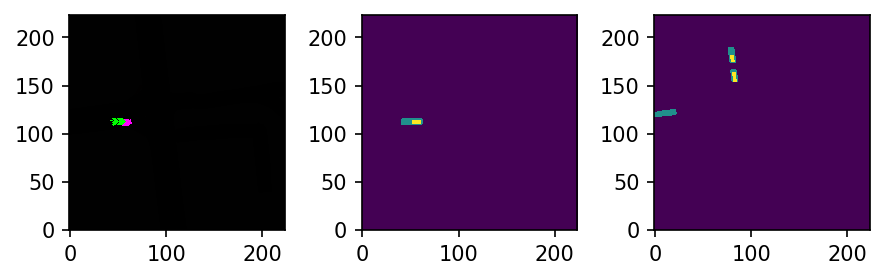

In [26]:
idx_sample = np.random.randint(gen_batch_size)
num_targets = np.sum(valTargetAvail.numpy(), axis=1)[idx_sample].astype(np.int32)


plt.figure(dpi=150)
plt.subplot(1,3,1)
img_aux = (np.copy(valSampleMapComp[idx_sample,:,:,:3].numpy())).astype(np.int32)
draw_trajectory(img_aux,
                transform_points(valSampeTargetPath[idx_sample,:num_targets,:2].numpy(), 
                                 valRasterFromAgent[idx_sample,:num_targets,:].numpy()),
                TARGET_POINTS_COLOR, 
                yaws=np.expand_dims(valSampeTargetPath[idx_sample,:num_targets,2].numpy(), axis=-1))
draw_trajectory(img_aux,
                transform_points(valSampeHistPath[idx_sample,:,:2].numpy(), 
                                 valRasterFromAgent[idx_sample,:,:].numpy()),
                (0, 255, 0), 
                yaws=np.expand_dims(valSampeHistPath[idx_sample,:,2].numpy(), axis=-1))

plt.imshow(img_aux, origin='botom')
plt.subplot(1,3,2)
plt.imshow(valSampleMapComp[idx_sample,:,:,3].numpy().astype(np.int32), origin='botom')
plt.subplot(1,3,3)
plt.imshow(valSampleMapComp[idx_sample,:,:,4].numpy().astype(np.int32), origin='botom')

plt.tight_layout()
plt.show()


In [81]:
valSampeHistPath[idx_sample].numpy()

array([[ 2.27373675e-13, -1.13686838e-13,  0.00000000e+00],
       [-1.56505179e+00, -2.73752473e-02, -4.14896011e-03],
       [-3.17245507e+00, -6.14949577e-02, -9.98139381e-03],
       [-4.80387402e+00, -1.00257963e-01, -1.07243061e-02],
       [-6.40527058e+00, -1.03562914e-01, -1.51770115e-02],
       [-7.97455120e+00, -9.68747810e-02, -1.52225494e-02],
       [-9.56992912e+00, -7.58346915e-02, -1.28762722e-02],
       [-1.11903448e+01, -5.27351908e-02, -1.23963356e-02],
       [-1.28210983e+01, -2.70275548e-02, -1.02908611e-02],
       [-1.44690876e+01,  3.45613388e-03, -1.17144585e-02],
       [-1.60941219e+01,  3.36015262e-02, -1.13334656e-02]], dtype=float32)

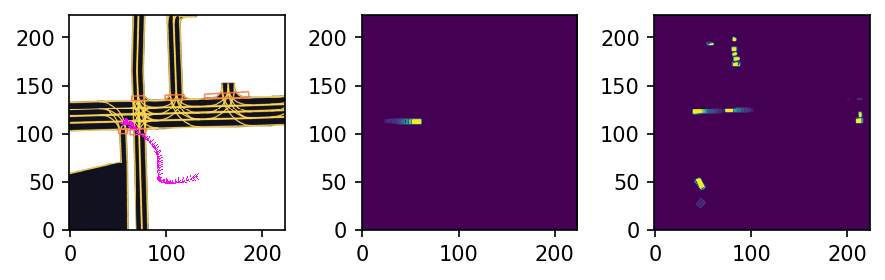

In [52]:
plt.figure(dpi=150)
plt.subplot(1,3,1)
img_aux = (np.copy(valSampleMapComp[idx_sample,:,:,:3].numpy())).astype(np.int32)
draw_trajectory(img_aux,
                transform_points(valPredPath[idx_sample,:num_targets,:2], 
                                 valRasterFromAgent[idx_sample,:num_targets,:].numpy()),
                TARGET_POINTS_COLOR, 
                yaws=np.expand_dims(valPredPath[idx_sample,:num_targets,2], axis=-1))

plt.imshow(img_aux, origin='botom')
plt.subplot(1,3,2)
plt.imshow(valSampleMapComp[idx_sample,:,:,3].numpy().astype(np.int32), origin='botom')
plt.subplot(1,3,3)
plt.imshow(valSampleMapComp[idx_sample,:,:,4].numpy().astype(np.int32), origin='botom')

plt.tight_layout()
plt.show()

13 14
58.3064
[0.58343095 1.2710873  1.9920269  2.6719837  3.298203   3.8973608
 4.499265   5.12152    5.7668667  6.4258943  7.081665   7.715186
 8.310427   8.857619  ]
[ 1.0070627  1.9528859  2.87924    3.7001054  4.826869   5.5209856
  6.4326777  7.497898   8.317387   8.891124   9.715045  10.570444
 11.444446  12.513167 ]
[ 0.00625564 -0.02951764 -0.0650873  -0.06337641 -0.06753968 -0.08458422
 -0.11656569 -0.16619252 -0.236773   -0.33132124 -0.45154858 -0.59695244
 -0.7642603  -0.94758797]
[-0.02736774 -0.02661168  0.00056666  0.01609155 -0.02782969 -0.04360578
 -0.01681016  0.04768497  0.04534054  0.03916385  0.03630602  0.00522138
 -0.00972332  0.03748717]


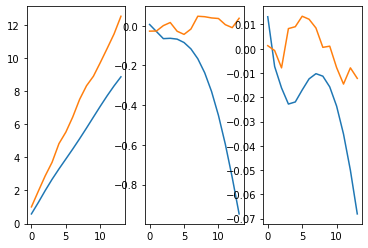

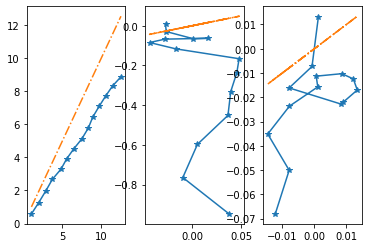

In [47]:
num_targets = np.sum(valTargetAvail.numpy(), axis=0)[idx_sample].astype(np.int32)

print(idx_sample, num_targets)
print(valLoss[idx_sample])
print(valPredPath[idx_sample,:num_targets,0])
print(valSampeTargetPath.numpy()[idx_sample,:num_targets,0])

plt.subplot(1,3,1)
plt.plot(valPredPath[idx_sample,:num_targets,0])
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,0])
print(valPredPath[idx_sample,:num_targets,1])
print(valSampeTargetPath.numpy()[idx_sample,:num_targets,1])
plt.subplot(1,3,2)
plt.plot(valPredPath[idx_sample,:num_targets,1])
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,1])
plt.subplot(1,3,3)
plt.plot(valPredPath[idx_sample,:num_targets,2])
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,2])

plt.figure()
plt.subplot(1,3,1)
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,0], valPredPath[idx_sample,:num_targets,0], '*-')
plt.plot(valSampeTargetPath[idx_sample,:num_targets,0], valSampeTargetPath[idx_sample,:num_targets,0], '-.')
plt.subplot(1,3,2)
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,1], valPredPath[idx_sample,:num_targets,1], '*-')
plt.plot(valSampeTargetPath[idx_sample,:num_targets,1], valSampeTargetPath[idx_sample,:num_targets,1], '-.')
plt.subplot(1,3,3)
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,2], valPredPath[idx_sample,:num_targets,2], '*-')
plt.plot(valSampeTargetPath[idx_sample,:num_targets,2], valSampeTargetPath[idx_sample,:num_targets,2], '-.')

In [28]:
from importlib import reload
reload(lyl_ts)
reload(lyl_nn)

<module 'LyftAgent_lib.topologies' from '/tf/2020-10-Lyft/Code/LyftAgent_lib/topologies.py'>

In [28]:
#   gen_lr_list: [0.001, 0.0001, 0.00005, 0.00001]
#   gen_lr_lims: [   10,     20,      30,     100]
 
#   teacher_force_list: [1.0, 0.75, 0.5, 0.25, 0.0, 0.0]
#   teacher_force_lims: [  5,   10,  20,   30, 50,  100]

#   future_steps_train_list: [50, 25, 15, 10, 5]
#   future_steps_train_lims: [20, 30, 40, 90, 100]

In [24]:
#   gen_lr_list: [0.001, 0.0001, 0.00005, 0.00001]
#   gen_lr_lims: [   5,     10,      20,     30]
 
#   teacher_force_list: [1.0, 0.75, 0.5, 0.25, 0.0, 0.0]
#   teacher_force_lims: [  2,    5,   7,   10,  20,  30]

#   future_steps_train_list: [50, 25, 15, 10, 5]
#   future_steps_train_lims: [ 7, 10, 15, 20, 30]